In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
import collections
import matplotlib.patches as mpatches
import time

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

import warnings
warnings.filterwarnings("ignore")

#### Luego de cargar las librerias definimos las variables presentes en el dataset a traves de la informacion proporcionada en la pagina de kaggle

 instant: índice del registro
 dteday: fecha
 season: estación (1: primavera, 2: verano, 3: otoño, 4: invierno)
 yr: año (0: 2011, 1: 2012)
 mnth: mes (1 a 12)
 holiday: día festivo o no (extraído de [Web Link])
 weekday: día de la semana
 workingday: si el día no es fin de semana ni festivo, es 1; de lo contrario, es 0.
 weathersit:
 1: Despejado, Pocas nubes, Parcialmente nublado, Parcialmente nublado
 2: Niebla + Nublado, Niebla + Nubes rotas, Niebla + Pocas nubes, Niebla
 3: Nieve ligera, Lluvia ligera + Tormenta eléctrica + Nubes dispersas, Lluvia ligera + Nubes dispersas
 4: Lluvia intensa + Granizo + Tormenta eléctrica + Niebla, Nieve + Niebla
 temp: Temperatura normalizada en Celsius. Los valores se derivan mediante (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (solo en escala horaria)
 atemp: Sensación térmica normalizada en Celsius. Los valores se derivan mediante (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (solo en escala horaria)
 hum: Humedad normalizada. Los valores se dividen por 100 (máximo)
 windspeed: Velocidad del viento normalizada. Los valores se dividen por 67 (máximo)
 casual: recuento de usuarios casuales
 registered: recuento de usuarios registrados
 cnt: recuento total de bicicletas de alquiler, incluyendo tanto usuarios casuales como registrados


#### Cargamos el archivo

In [5]:
ruta_archivo = 'Desktop/Augusto/Datasets para pruebas/Bicis/day.csv'
df_bicis = pd.read_csv(ruta_archivo)
df_bicis

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


 Vemos los tipos de datos presentes

In [7]:
df_bicis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


 Renombramos las columnas para mayor compresion en español

In [9]:
df_bicismod = df_bicis.rename(columns={'instant':'Rec_id','dteday':'Fecha_y_Hora','season':'Estacion','yr':'Año','mnth':'Mes','holiday' : 'Feriado','weathersit':'Condicion_climatica',
                         'hum':'Humedad','cnt':'Conteo_Total', 'windspeed' : 'Velocidad_viento', 'casual' : 'Casual', 'registered' : 'Registrados', 'cnt': 'Recuento', 'temp': 'Temperatura',
                                      'weekday' : 'Dia_de_la_semana', 'atemp': 'Temp_normalizada', 'workingday': 'Dia_de_trabajo'})
df_bicismod

,Rec_id,Fecha_y_Hora,Estacion,Año,Mes,Feriado,Dia_de_la_semana,Dia_de_trabajo,Condicion_climatica,Temperatura,Temp_normalizada,Humedad,Velocidad_viento,Casual,Registrados,Recuento
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


Vemos que se hayan efectuado los cambios

In [11]:
df_bicismod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Rec_id               731 non-null    int64  
 1   Fecha_y_Hora         731 non-null    object 
 2   Estacion             731 non-null    int64  
 3   Año                  731 non-null    int64  
 4   Mes                  731 non-null    int64  
 5   Feriado              731 non-null    int64  
 6   Dia_de_la_semana     731 non-null    int64  
 7   Dia_de_trabajo       731 non-null    int64  
 8   Condicion_climatica  731 non-null    int64  
 9   Temperatura          731 non-null    float64
 10  Temp_normalizada     731 non-null    float64
 11  Humedad              731 non-null    float64
 12  Velocidad_viento     731 non-null    float64
 13  Casual               731 non-null    int64  
 14  Registrados          731 non-null    int64  
 15  Recuento             731 non-null    int

Recategorizamos columnas

In [13]:
df_bicismod['Fecha_y_Hora'] = pd.to_datetime(df_bicismod['Fecha_y_Hora'])
df_bicismod['Estacion'] = df_bicismod['Estacion'].astype('category')
df_bicismod['Año'] = df_bicismod['Año'].astype('category')
df_bicismod['Mes'] = df_bicismod['Mes'].astype('category')
df_bicismod['Feriado'] = df_bicismod['Feriado'].astype('category')
df_bicismod['Dia_de_la_semana'] = df_bicismod['Dia_de_la_semana'].astype('category')
df_bicismod['Dia_de_trabajo'] = df_bicismod['Dia_de_trabajo'].astype('category')
df_bicismod['Condicion_climatica'] = df_bicismod['Condicion_climatica'].astype('category')


Ahora solo nos quedaron como variables numericas las que no son categoricas

In [15]:
df_bicismod.describe()

,Rec_id,Temperatura,Temp_normalizada,Humedad,Velocidad_viento,Casual,Registrados,Recuento
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


Analizando un poco las variables climatologicas

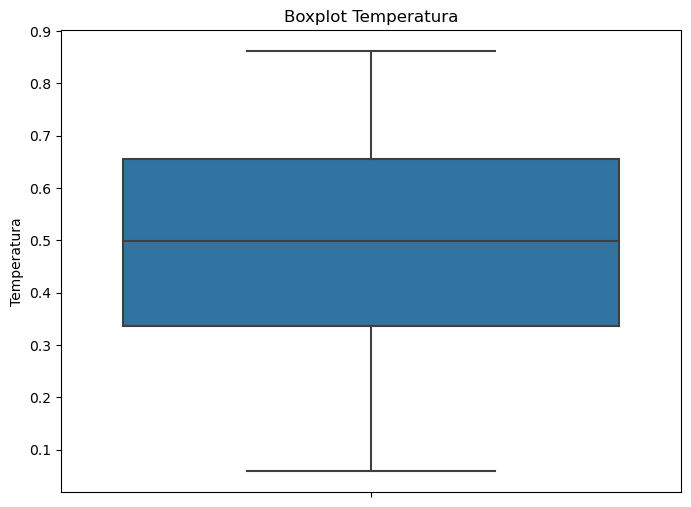

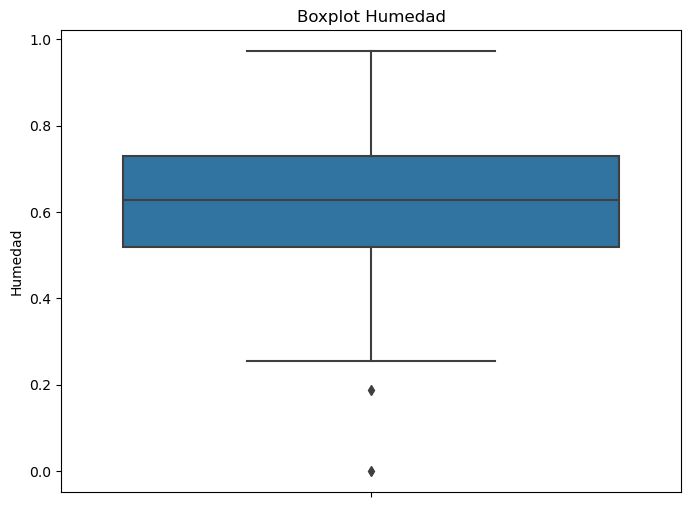

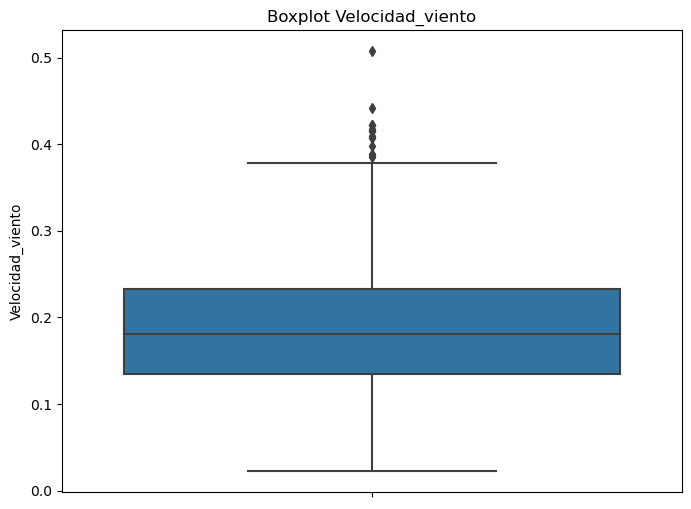

In [17]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_bicismod, y='Temperatura')
plt.title('Boxplot Temperatura')
plt.ylabel('Temperatura')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_bicismod, y='Humedad')
plt.title('Boxplot Humedad')
plt.ylabel('Humedad')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_bicismod, y='Velocidad_viento')
plt.title('Boxplot Velocidad_viento')
plt.ylabel('Velocidad_viento')
plt.show()

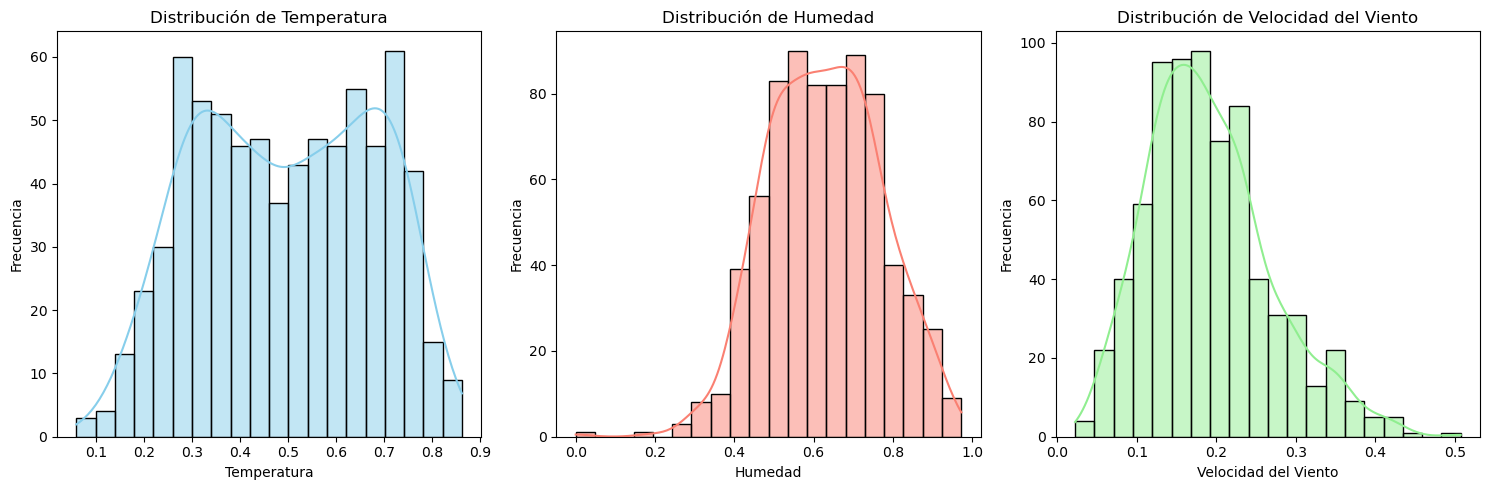

In [18]:
plt.figure(figsize=(15, 5))

# Histograma de Temperatura
plt.subplot(1, 3, 1)
sns.histplot(data=df_bicismod, x='Temperatura', bins=20, kde=True, color='skyblue')
plt.title('Distribución de Temperatura')
plt.xlabel('Temperatura')
plt.ylabel('Frecuencia')

# Histograma de Humedad
plt.subplot(1, 3, 2)
sns.histplot(data=df_bicismod, x='Humedad', bins=20, kde=True, color='salmon')
plt.title('Distribución de Humedad')
plt.xlabel('Humedad')
plt.ylabel('Frecuencia')

# Histograma de Velocidad del viento
plt.subplot(1, 3, 3)
sns.histplot(data=df_bicismod, x='Velocidad_viento', bins=20, kde=True, color='lightgreen')
plt.title('Distribución de Velocidad del Viento')
plt.xlabel('Velocidad del Viento')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

No existe similitud entre los patrones de las medidas ambientales

Buscamos correlacion entre variables con este mapa de calor

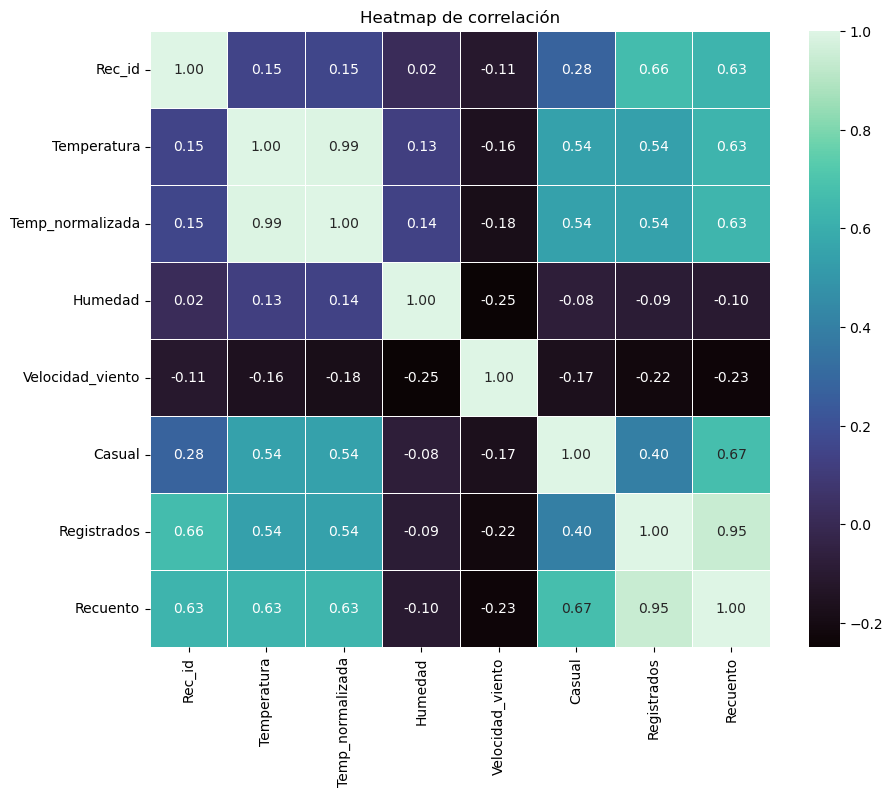

In [21]:
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(df_bicismod.corr(), annot=True, cmap='mako', fmt='.2f', linewidths=0.5)
plt.title('Heatmap de correlación')
plt.show()

La temperatura aumenta el uso casual de las bicis? 
La humedad disminuye el uso casual de las bicis?
El viento influye en el uso casual de las bicis?

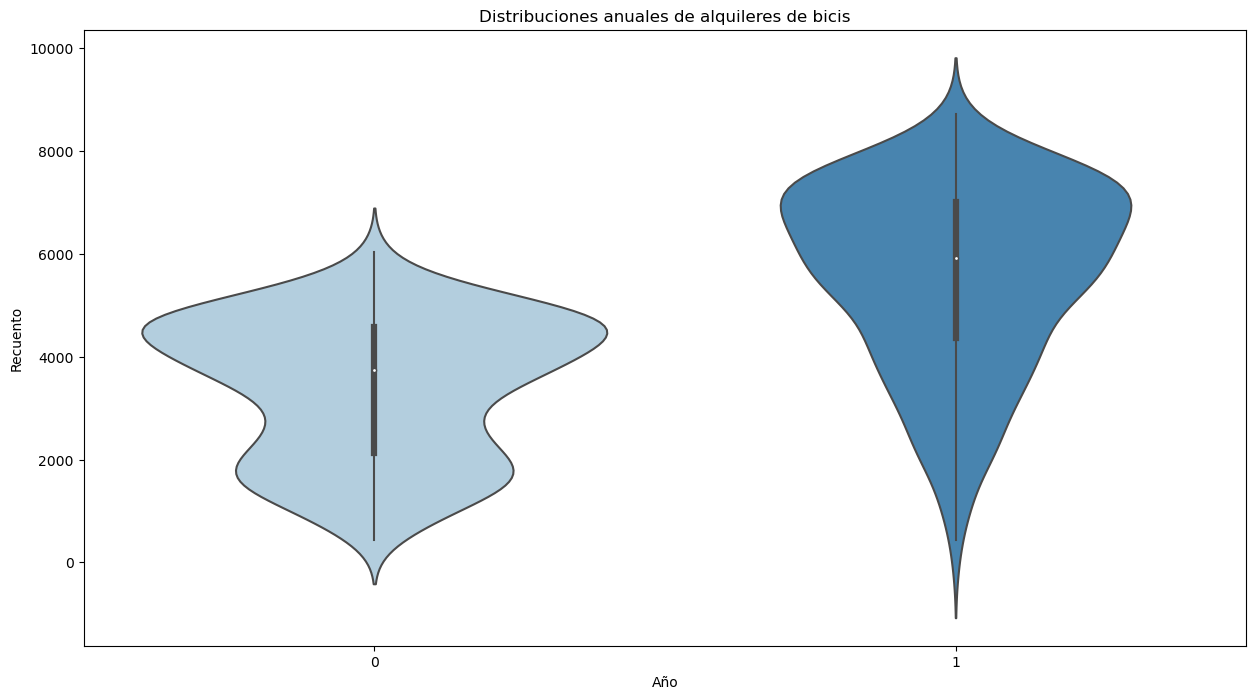

In [23]:
fig,ax=plt.subplots(figsize=(15,8))
sns.violinplot(x='Año',y='Recuento',data=df_bicismod[['Año','Recuento']], palette = 'Blues')
ax.set_title('Distribuciones anuales de alquileres de bicis')
plt.show()

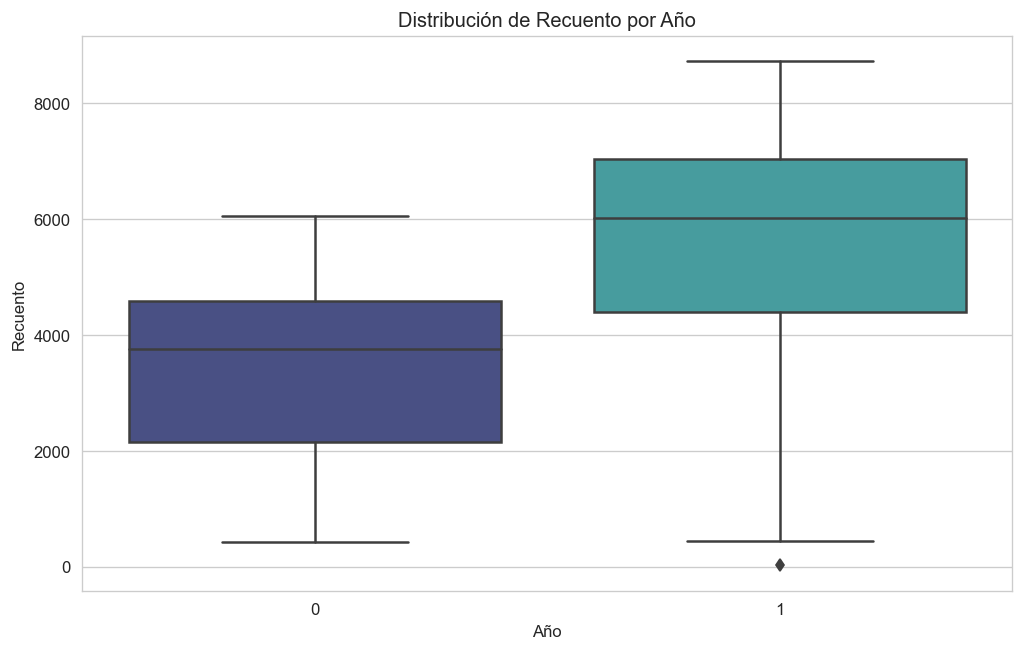

In [100]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Año', y='Recuento', data=df_bicismod, palette='mako')
plt.title('Distribución de Recuento por Año')
plt.xlabel('Año')
plt.ylabel('Recuento')
plt.show()

In [97]:
continous_col=['Temperatura','Temp_normalizada','Humedad','Velocidad_viento','Casual','Registrados']

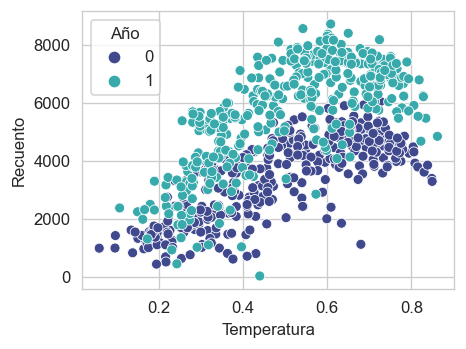

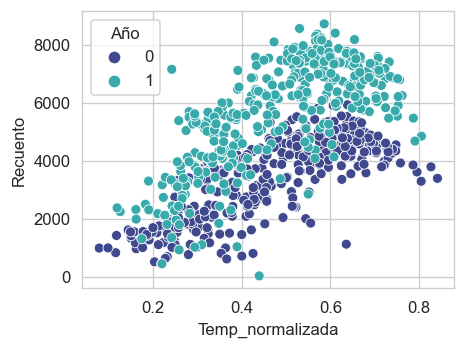

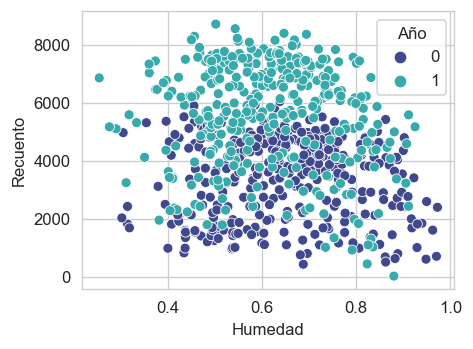

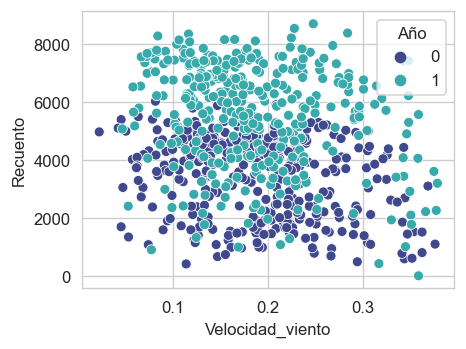

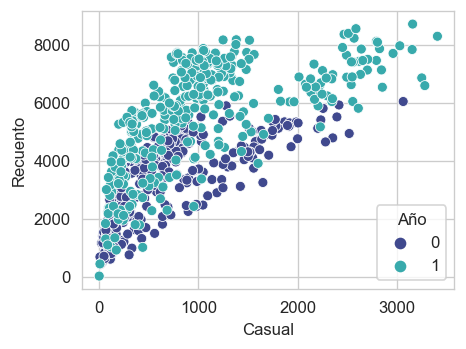

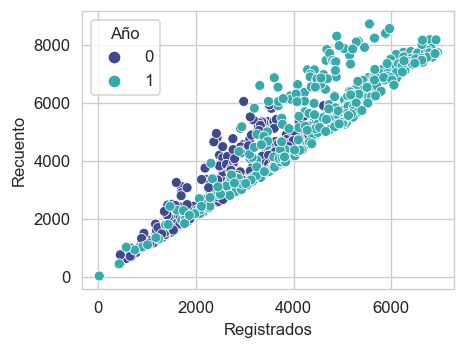

In [99]:
for col in continous_col:
    plt.figure(figsize=(4,3))
    sns.scatterplot(data=df_bicismod,x=col,y='Recuento',hue = df_bicismod['Año'], palette='mako')
    plt.show()

In [25]:
valor_minimo_recuento = df_bicismod['Recuento'].min()
print("El valor mínimo de 'Recuento' es:", valor_minimo_recuento)

El valor mínimo de 'Recuento' es: 22


In [26]:
filtro = (df_bicismod['Año'] == 1) & (df_bicismod['Recuento'] == 22)
registros_recuento_cero_año1 = df_bicismod[filtro]
registros_recuento_cero_año1

,Rec_id,Fecha_y_Hora,Estacion,Año,Mes,Feriado,Dia_de_la_semana,Dia_de_trabajo,Condicion_climatica,Temperatura,Temp_normalizada,Humedad,Velocidad_viento,Casual,Registrados,Recuento
667,668,2012-10-29,4,1,10,0,1,1,3,0.44,0.4394,0.88,0.3582,2,20,22


#### Huracan Sandy?

Graficamente se aprecia como existe un aumento en la frecuencia de alquileres entre el primer y el segundo año de monitoreo

Analizamos graficamente de que manera se distribuyen los alquileres de bicis a lo largo de los meses
Se discrimina tambien por estacion del año

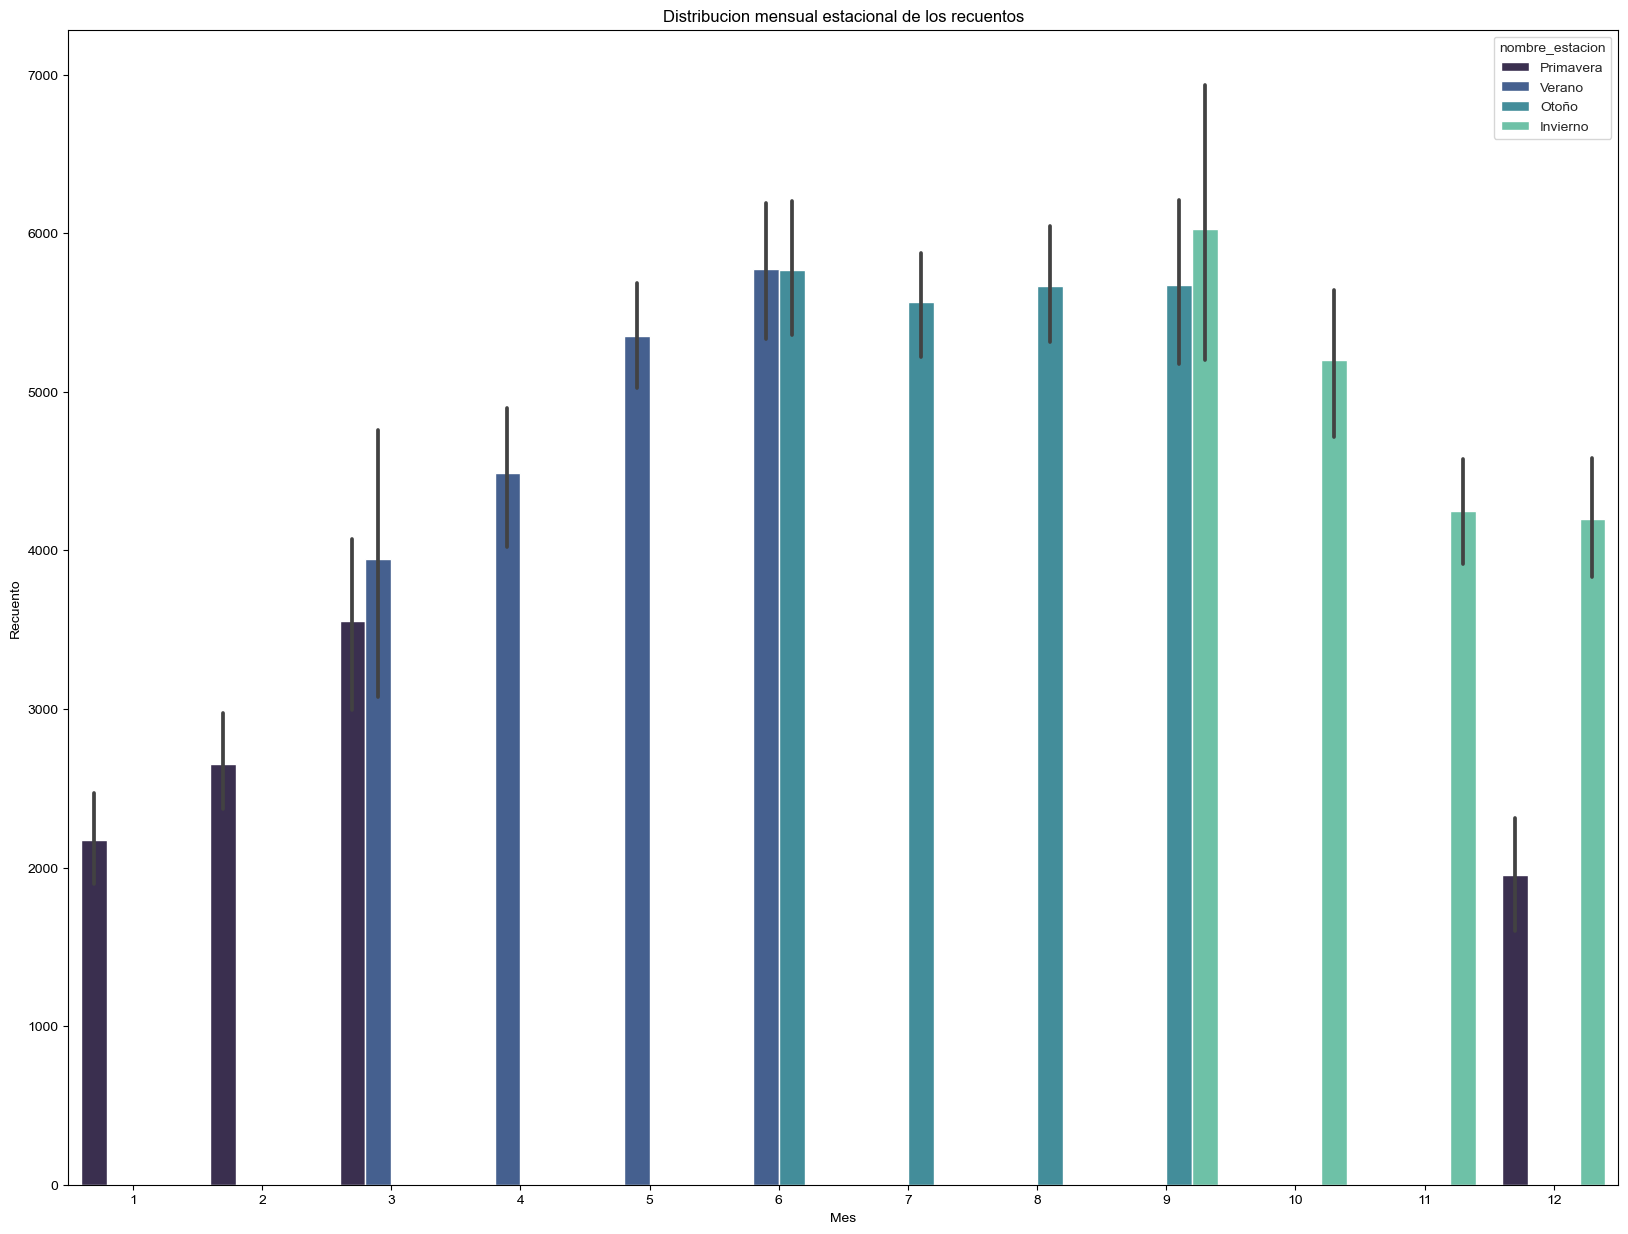

In [30]:
nombres_estaciones = {1: 'Primavera', 2: 'Verano', 3: 'Otoño', 4: 'Invierno'}


df_bicismod['nombre_estacion'] = df_bicismod['Estacion'].map(nombres_estaciones)

fig, ax = plt.subplots(figsize=(20, 15))
sns.set_style('whitegrid')

sns.barplot(x='Mes', y='Recuento', data=df_bicismod, hue='nombre_estacion', ax=ax, palette = 'mako')
ax.set_title('Distribucion mensual estacional de los recuentos')
plt.show()


Realizamos un conteo para ver de manera agregada los valores correspondientes a cada Estacion

In [32]:
conteo_por_estacion = df_bicismod.groupby('Estacion')['Recuento'].sum().sort_values().reset_index()
print(conteo_por_estacion)

  Estacion  Recuento
0        1    471348
1        4    841613
2        2    918589
3        3   1061129


Podemos apreciar que la estacion 3, osea Otoño es donde mas alquileres se dieron tanto casuales como registrados

Mismo procedimiento pero discriminando por dia de la semana

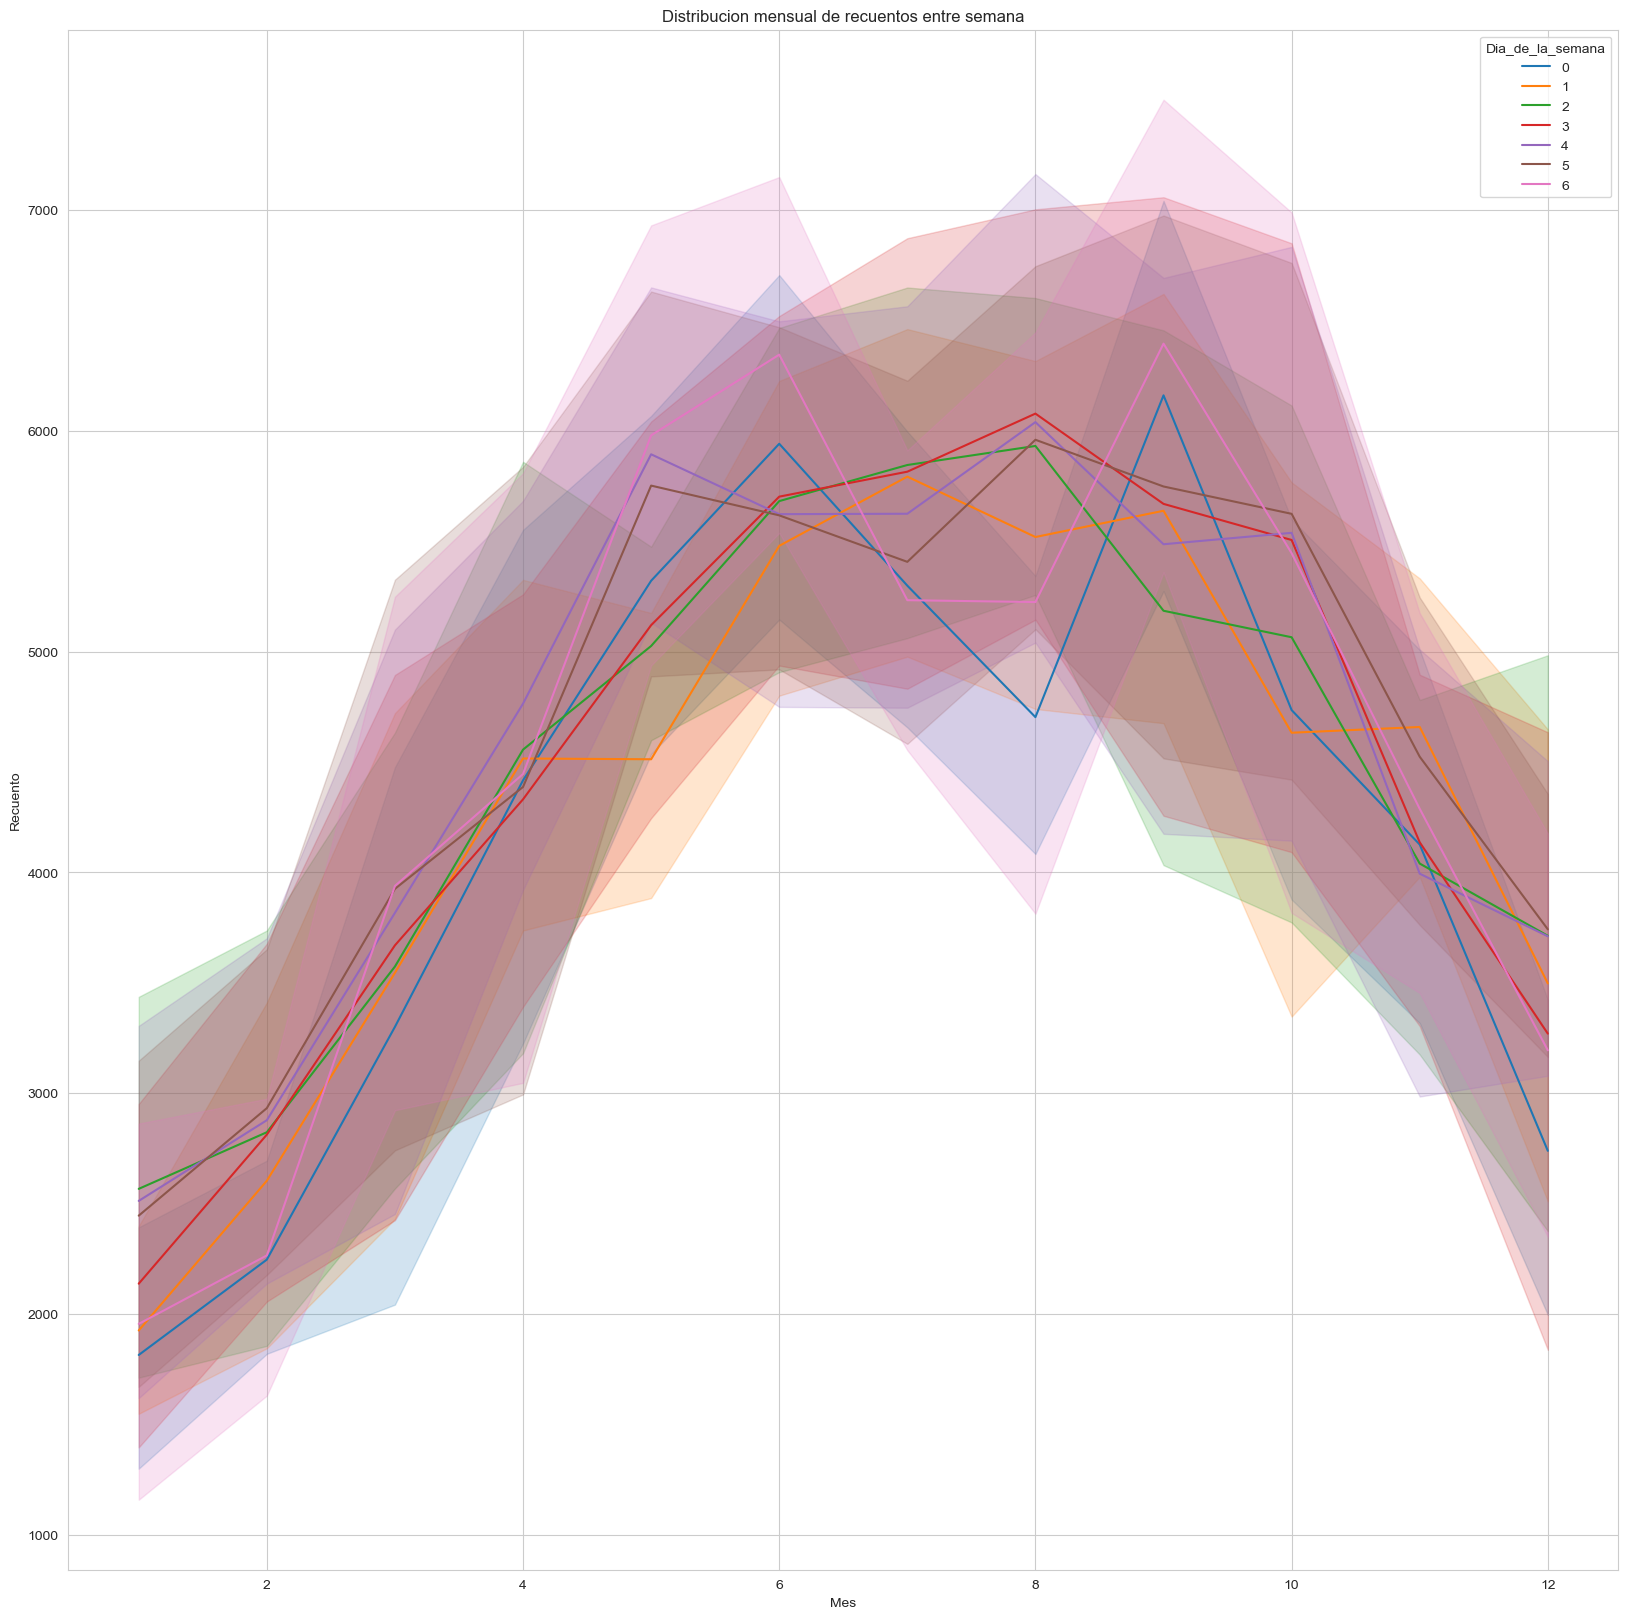

In [35]:
fig,ax=plt.subplots(figsize=(20,20))
sns.set_style('whitegrid')

sns.lineplot(x='Mes',y='Recuento',data=df_bicismod[['Mes','Recuento','Dia_de_la_semana']],hue='Dia_de_la_semana',ax=ax)
ax.set_title('Distribucion mensual de recuentos entre semana')
plt.show()


Parece que dependiendo del mes, cambia el dia que mas se utilizan las bicis

Realizamos un conteo por mes para analizar la cantidad total utilizada de bicicletas 

In [38]:
conteo_por_mes = df_bicismod.groupby('Mes')['Recuento'].sum().sort_values().reset_index()
print(conteo_por_mes)

   Mes  Recuento
0    1    134933
1    2    151352
2   12    211036
3    3    228920
4   11    254831
5    4    269094
6   10    322352
7    5    331686
8    7    344948
9    9    345991
10   6    346342
11   8    351194


Se convalida entonces que los meses de mayores alquileres de bicis sean entonces los pertenecientes al otoño

Analizamos los tipos de alquileres por separado (Registrados ; Casual)

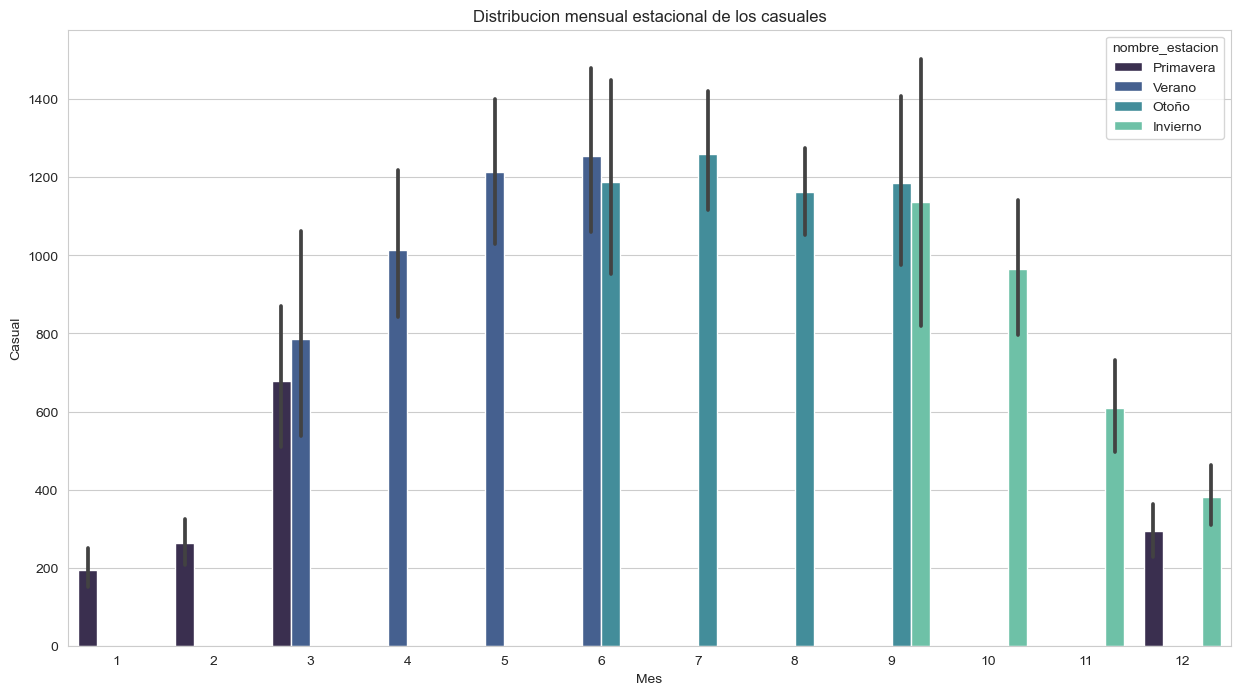

In [41]:
fig,ax=plt.subplots(figsize=(15,8))
sns.set_style('whitegrid')
sns.barplot(x='Mes', y='Casual', data=df_bicismod, hue='nombre_estacion', ax=ax, palette = 'mako')
ax.set_title('Distribucion mensual estacional de los casuales')
plt.show()


In [42]:
conteo_casual_por_estacion = df_bicismod.groupby('Estacion')['Casual'].sum().sort_values().reset_index()
print(conteo_casual_por_estacion)

  Estacion  Casual
0        1   60622
1        4  129782
2        2  203522
3        3  226091


Mayor estacion con alquileres casuales N°3 (Otoño)

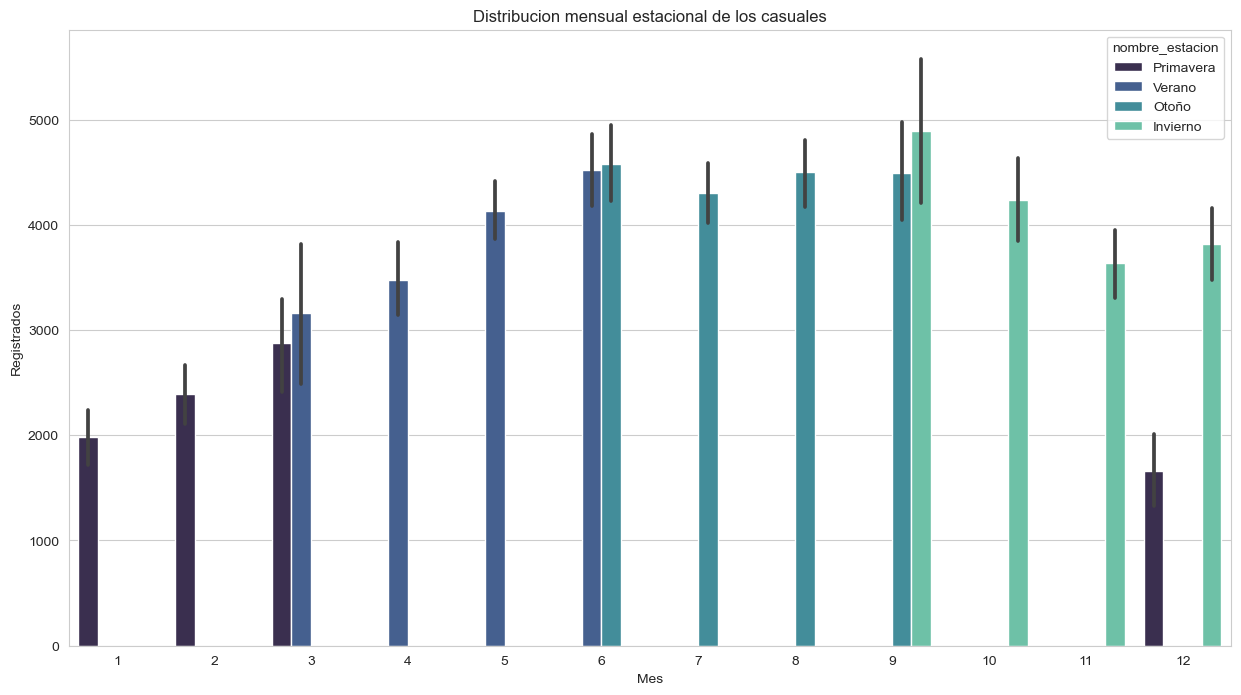

In [44]:
fig,ax=plt.subplots(figsize=(15,8))
sns.set_style('whitegrid')
sns.barplot(x='Mes', y='Registrados', data=df_bicismod, hue='nombre_estacion', ax=ax,  palette = 'mako')
ax.set_title('Distribucion mensual estacional de los casuales')
plt.show()

In [45]:
conteo_registrados_por_estacion = df_bicismod.groupby('Estacion')['Registrados'].sum().sort_values().reset_index()
print(conteo_registrados_por_estacion)

  Estacion  Registrados
0        1       410726
1        4       711831
2        2       715067
3        3       835038


Mayor estacion con alquileres Registrados N°3 (Otoño)

Que dia de la semana mas se usan los alquileres de bici?

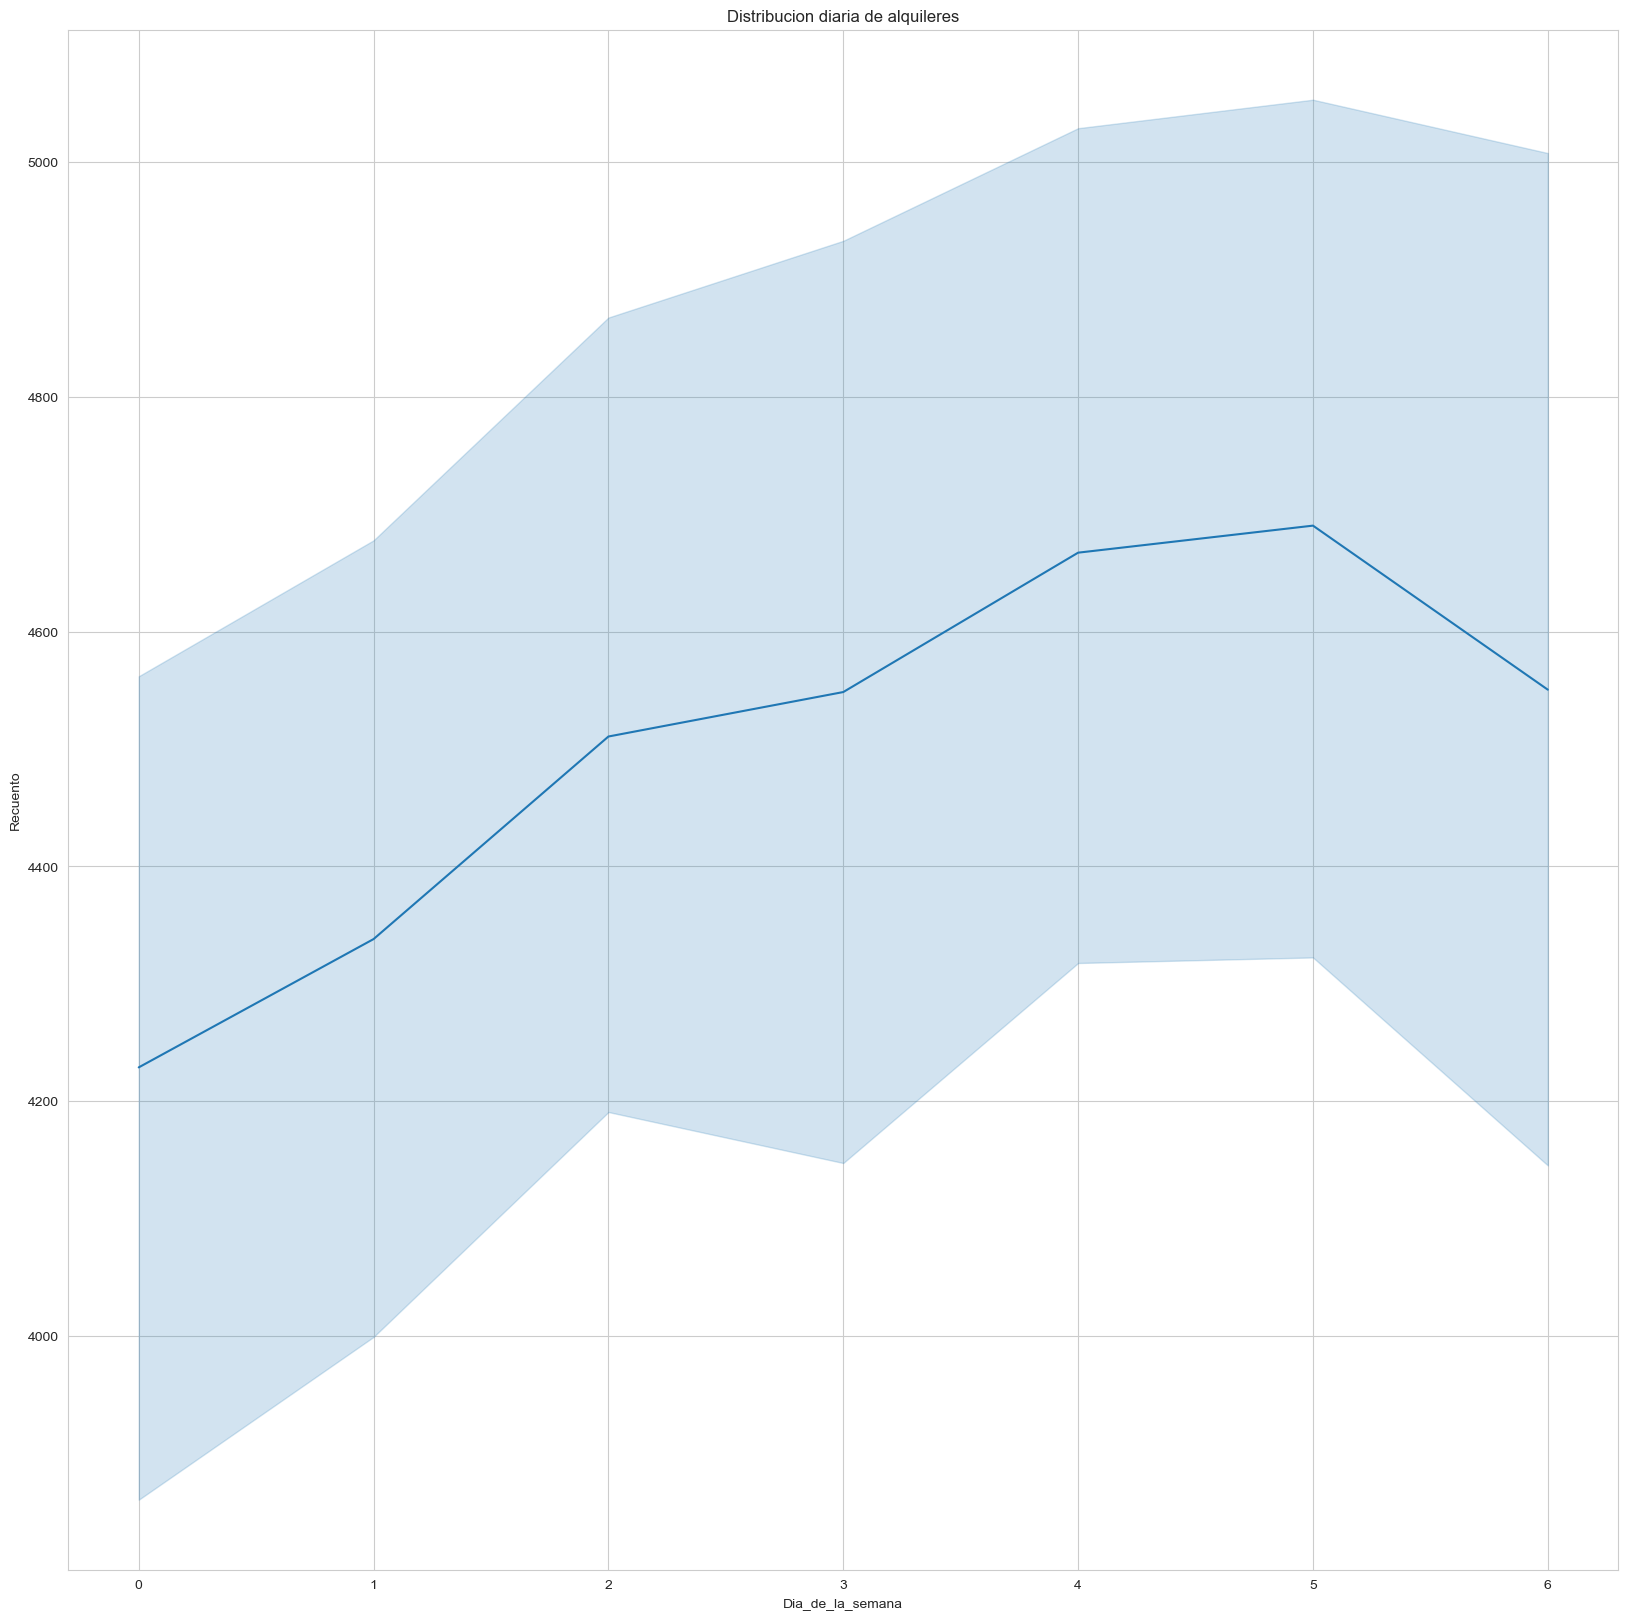

In [48]:
fig,ax=plt.subplots(figsize=(20,20))
sns.set_style('whitegrid')

sns.lineplot(x='Dia_de_la_semana',y='Recuento',data=df_bicismod, ax=ax)
ax.set_title('Distribucion diaria de alquileres')
plt.show()

In [49]:
conteo_por_dia = df_bicismod.groupby('Dia_de_la_semana')['Recuento'].sum().sort_values().reset_index()
print(conteo_por_dia)

  Dia_de_la_semana  Recuento
0                0    444027
1                1    455503
2                2    469109
3                3    473048
4                6    477807
5                4    485395
6                5    487790


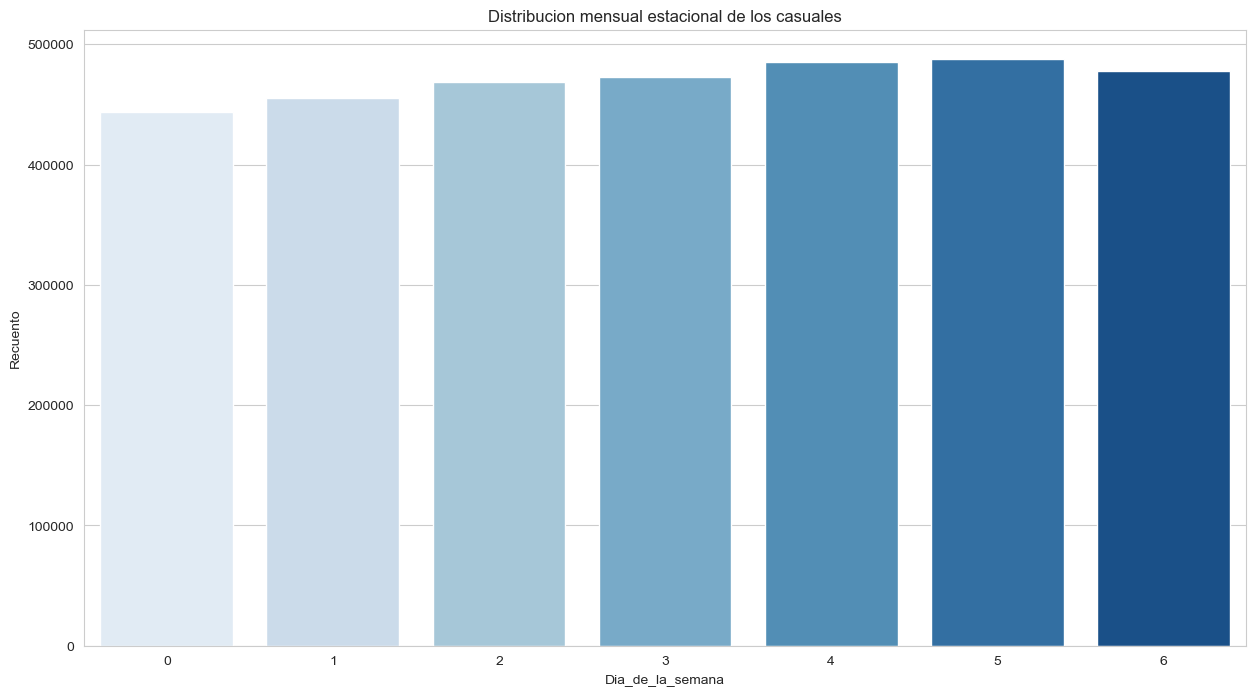

In [50]:
conteo_por_dia = df_bicismod.groupby('Dia_de_la_semana')['Recuento'].sum().sort_values().reset_index()

fig, ax = plt.subplots(figsize=(15, 8))
sns.set_style('whitegrid')
sns.barplot(x='Dia_de_la_semana', y='Recuento', palette = 'Blues', data=conteo_por_dia, ax=ax)
ax.set_title('Distribucion mensual estacional de los casuales')
plt.show()

#### El dia que se presentan mas alquileres de bicis son los viernes

In [52]:
df_bicismod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Rec_id               731 non-null    int64         
 1   Fecha_y_Hora         731 non-null    datetime64[ns]
 2   Estacion             731 non-null    category      
 3   Año                  731 non-null    category      
 4   Mes                  731 non-null    category      
 5   Feriado              731 non-null    category      
 6   Dia_de_la_semana     731 non-null    category      
 7   Dia_de_trabajo       731 non-null    category      
 8   Condicion_climatica  731 non-null    category      
 9   Temperatura          731 non-null    float64       
 10  Temp_normalizada     731 non-null    float64       
 11  Humedad              731 non-null    float64       
 12  Velocidad_viento     731 non-null    float64       
 13  Casual               731 non-null  

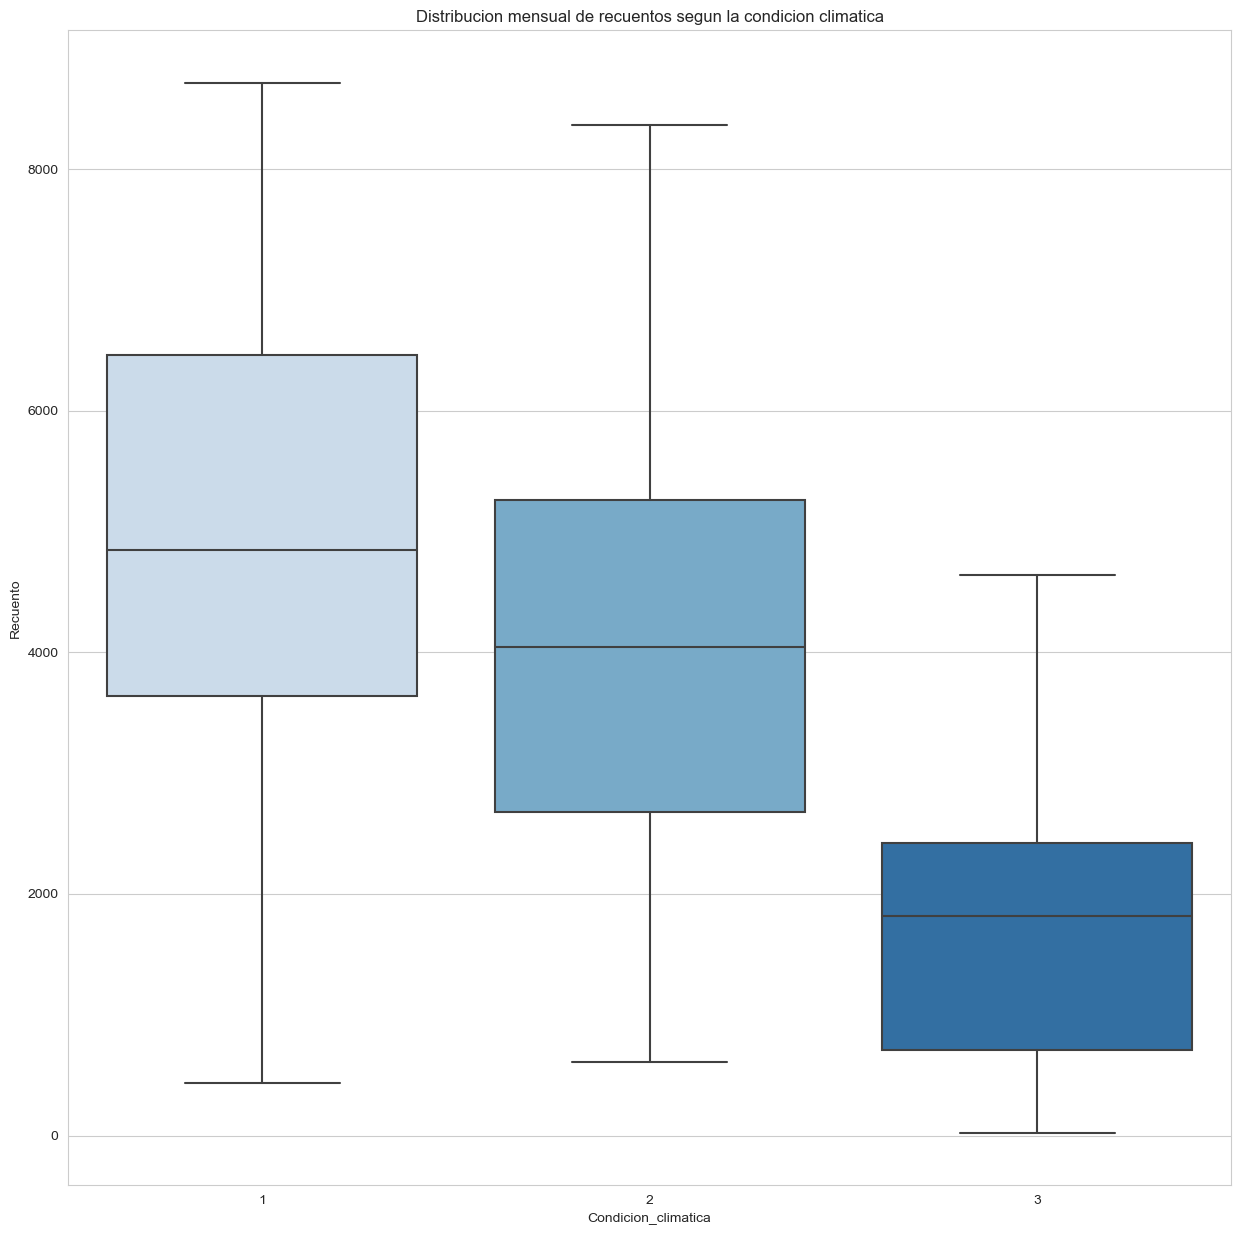

In [53]:
fig,ax1=plt.subplots(figsize=(15,15))

sns.boxplot(x='Condicion_climatica',y='Recuento',data=df_bicismod[['Mes','Recuento','Condicion_climatica']],ax=ax1, palette = 'Blues')
ax1.set_title('Distribucion mensual de recuentos segun la condicion climatica')
plt.show()

In [54]:
df_bicismod['Condicion_climatica'].value_counts()

1    463
2    247
3     21
Name: Condicion_climatica, dtype: int64

#### 1: Despejado, Pocas nubes, Parcialmente nublado, Parcialmente nublado (Mas elegido para alquilar)
#### 2: Niebla + Nublado, Niebla + Nubes rotas, Niebla + Pocas nubes, Niebla
#### 3: Nieve ligera, Lluvia ligera + Tormenta eléctrica + Nubes dispersas, Lluvia ligera + Nubes dispersas
#### 4: Lluvia intensa + Granizo + Tormenta eléctrica + Niebla, Nieve + Niebla

Analizamos la presencia de outliers

In [56]:
columns_of_interest = ['Velocidad_viento', 'Humedad']

Q1 = df_bicismod[columns_of_interest].quantile(0.25)
Q3 = df_bicismod[columns_of_interest].quantile(0.75)
IQR = Q3 - Q1

umbral = 1.5

outliers_count = ((df_bicismod[columns_of_interest] < (Q1 - umbral * IQR)) | (df_bicismod[columns_of_interest] > (Q3 + umbral * IQR))).sum()

print("Cantidad de outliers:")
print(outliers_count)


Cantidad de outliers:
Velocidad_viento    13
Humedad              2
dtype: int64


In [57]:
columns_with_outliers = ['Velocidad_viento', 'Humedad']

for column in columns_with_outliers:
    outliers_mask = ((df_bicismod[column] < (Q1[column] - umbral * IQR[column])) | 
                     (df_bicismod[column] > (Q3[column] + umbral * IQR[column])))
    
    df_bicismod = df_bicismod[~outliers_mask]

print("Después de eliminar registros con outliers:")
print(df_bicismod.shape)


Después de eliminar registros con outliers:
(717, 17)


Outliers eliminados

#### Procedemos a realizar analisis para entrenar el modelo

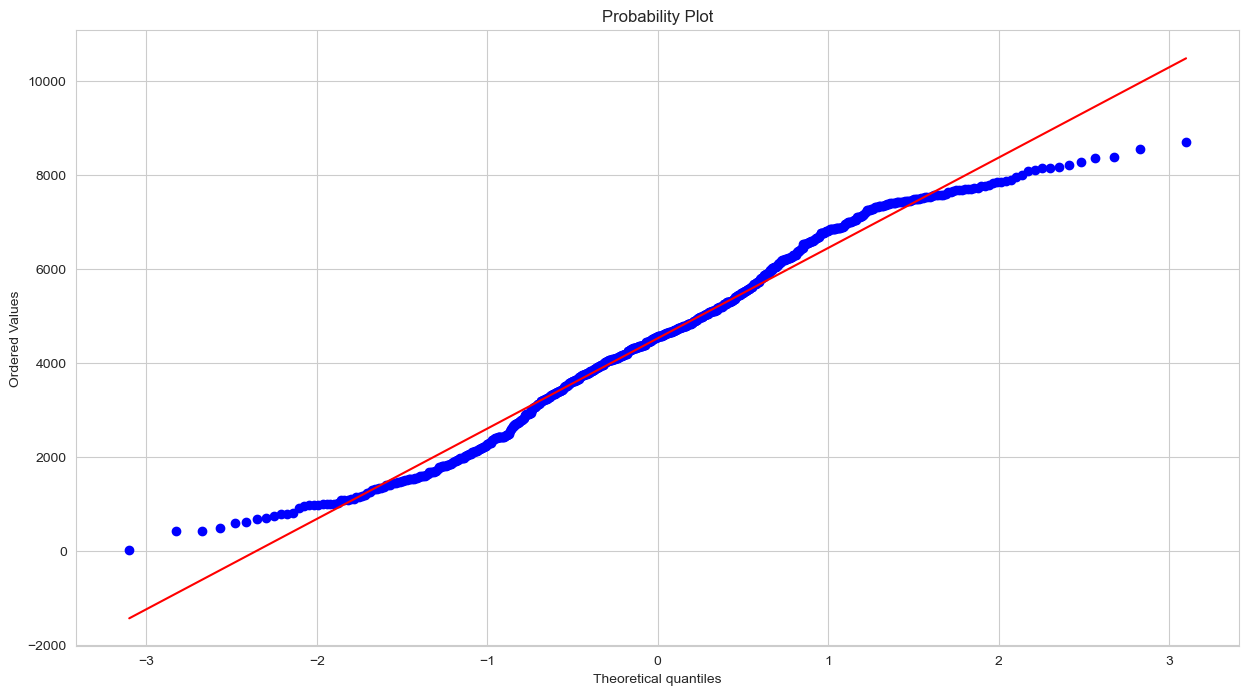

In [58]:
import scipy
from scipy import stats
fig=plt.figure(figsize=(15,8))
stats.probplot(df_bicismod.Recuento.tolist(),dist='norm',plot=plt)
plt.show()

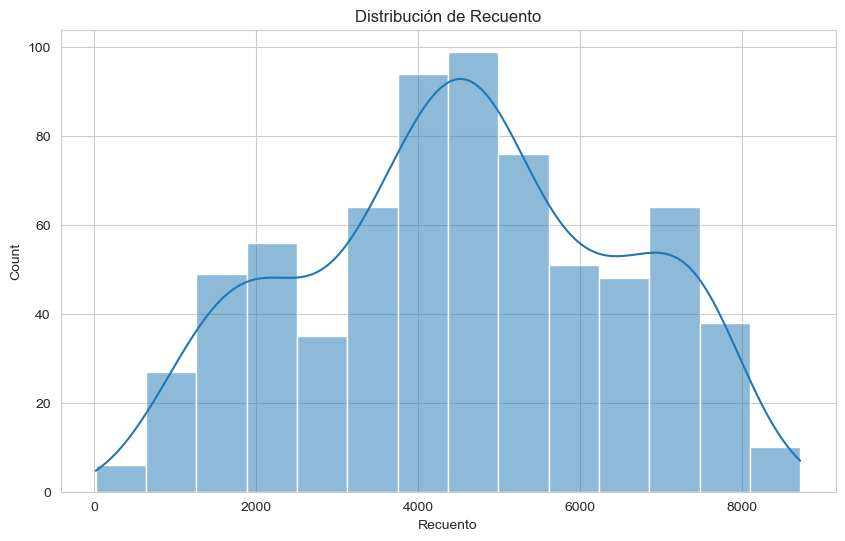

In [59]:
plt.figure(figsize=(10, 6))
sns.histplot(df_bicismod['Recuento'], kde=True)
plt.title('Distribución de Recuento')
plt.show()


In [60]:
df_bicismod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 717 entries, 0 to 730
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Rec_id               717 non-null    int64         
 1   Fecha_y_Hora         717 non-null    datetime64[ns]
 2   Estacion             717 non-null    category      
 3   Año                  717 non-null    category      
 4   Mes                  717 non-null    category      
 5   Feriado              717 non-null    category      
 6   Dia_de_la_semana     717 non-null    category      
 7   Dia_de_trabajo       717 non-null    category      
 8   Condicion_climatica  717 non-null    category      
 9   Temperatura          717 non-null    float64       
 10  Temp_normalizada     717 non-null    float64       
 11  Humedad              717 non-null    float64       
 12  Velocidad_viento     717 non-null    float64       
 13  Casual               717 non-null  

In [102]:
from scipy.stats import shapiro

stat, p_value = shapiro(df_bicismod['Recuento'])
print(f'Statistic: {stat}, p-value: {p_value}')

alpha = 0.05
if p_value > alpha:
    print("No se puede rechazar la hipótesis nula: los datos parecen seguir una distribución normal.")
else:
    print("Se rechaza la hipótesis nula: los datos no parecen seguir una distribución normal.")


Statistic: 0.9802423119544983, p-value: 2.948698529792182e-08
Se rechaza la hipótesis nula: los datos no parecen seguir una distribución normal.


#### Los valores del recuento total de alquileres no sigue una distribucion normal

In [62]:
from sklearn.metrics import r2_score
from sklearn.tree import export_graphviz
from IPython.display import Image  
import pydotplus
import matplotlib.pyplot as plt
import seaborn as sns

X = df_bicismod[['Temperatura', 'Casual', 'Velocidad_viento', 'Humedad','Registrados']]
y = df_bicismod['Recuento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tree_model = DecisionTreeRegressor(random_state=42)

tree_model.fit(X_train, y_train)

y_pred = tree_model.predict(X_test)

# Calcular R²
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')



R-squared: 0.992496303852753


#### Obtuvimos un R2 bastante elevado, vamos a realizar pruebas de cross validation para ver si no existe overfitting

Cross-Validation R²: 0.9889702242307331


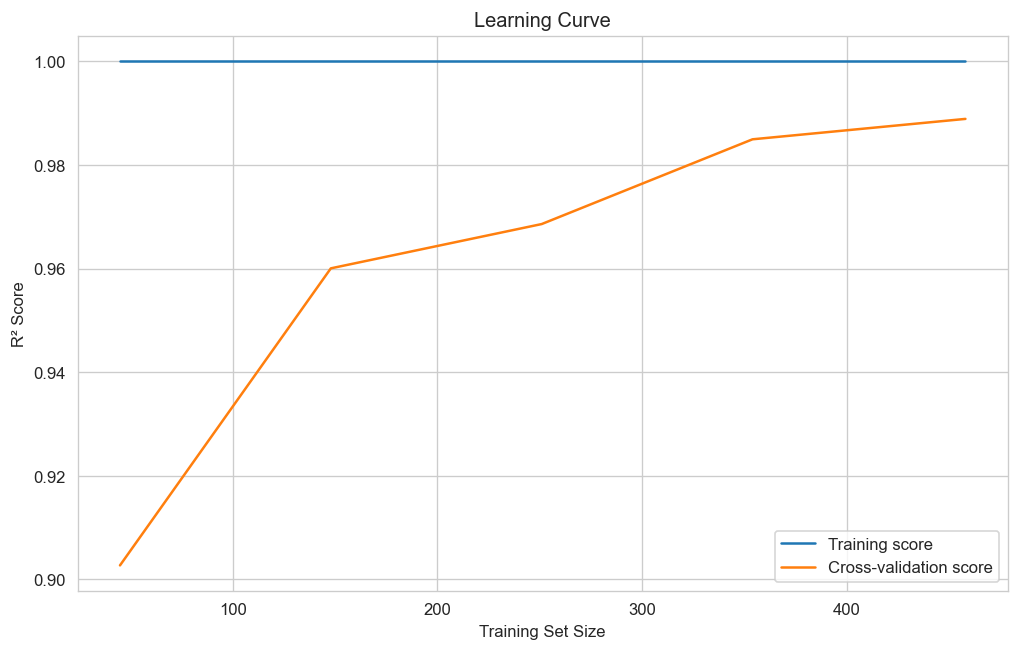

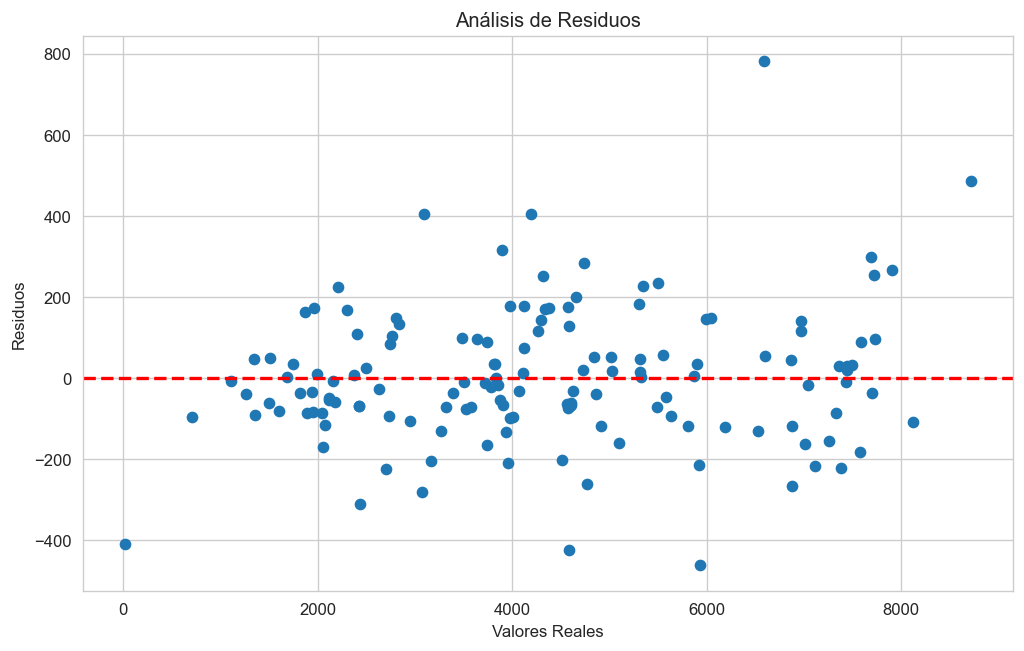

In [103]:
from sklearn.model_selection import cross_val_score, cross_validate, learning_curve, train_test_split
from sklearn.metrics import make_scorer

cv_scores = cross_val_score(tree_model, X_train, y_train, cv=5, scoring='r2')
print(f"Cross-Validation R²: {np.mean(cv_scores)}")

train_sizes, train_scores, test_scores = learning_curve(tree_model, X_train, y_train, cv=5, scoring='r2')
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
plt.xlabel('Training Set Size')
plt.ylabel('R² Score')
plt.title('Learning Curve')
plt.legend()
plt.show()

# Análisis de residuos en el conjunto de prueba
tree_model.fit(X_train, y_train)
y_pred = tree_model.predict(X_test)

residuos = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuos)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Residuos')
plt.title('Análisis de Residuos')
plt.show()


In [105]:
residuos = y_test - y_pred


In [108]:
from scipy.stats import shapiro

stat, p_value = shapiro(residuos)
print(f'Statistic: {stat}, p-value: {p_value}')

Statistic: 0.9557698369026184, p-value: 0.00014329489204101264


La prueba de Shapiro-Wilk indica que los residuos no siguen una distribución normal

Graficamente

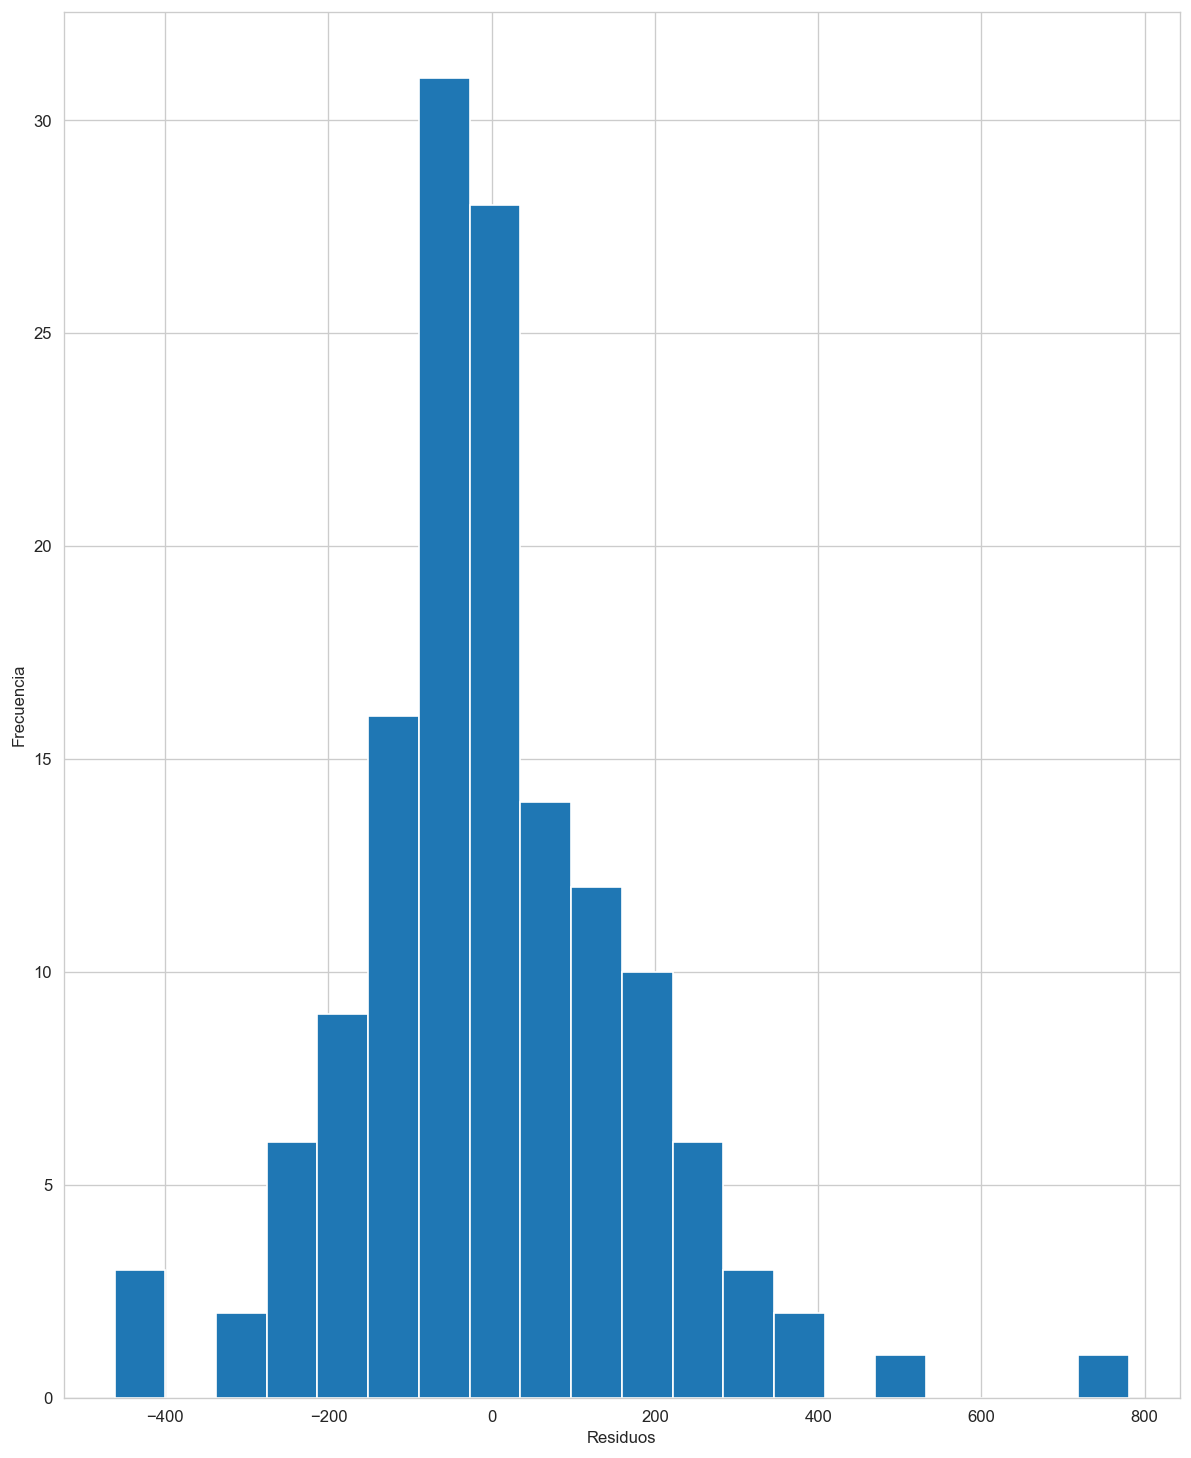

In [107]:
plt.hist(residuos, bins=20)
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.show()

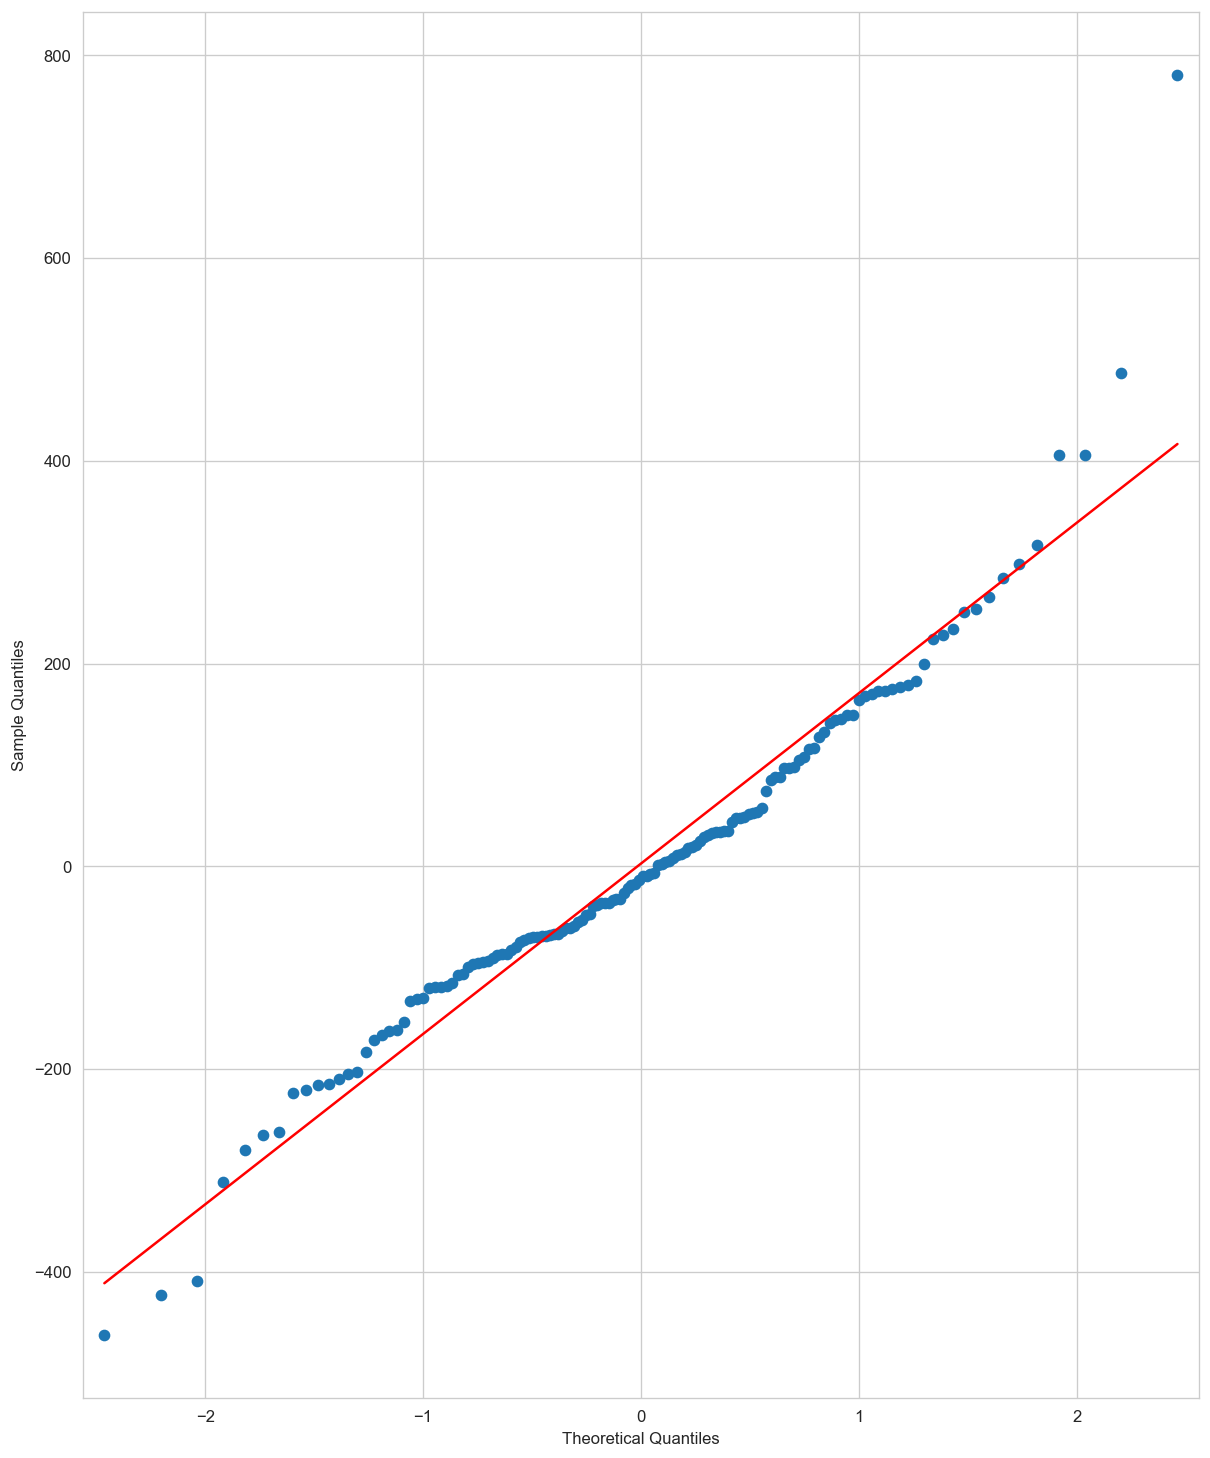

In [111]:
sm.qqplot(residuos, line='s')
plt.show()

Los residuos tienen una distribución similar a una normal

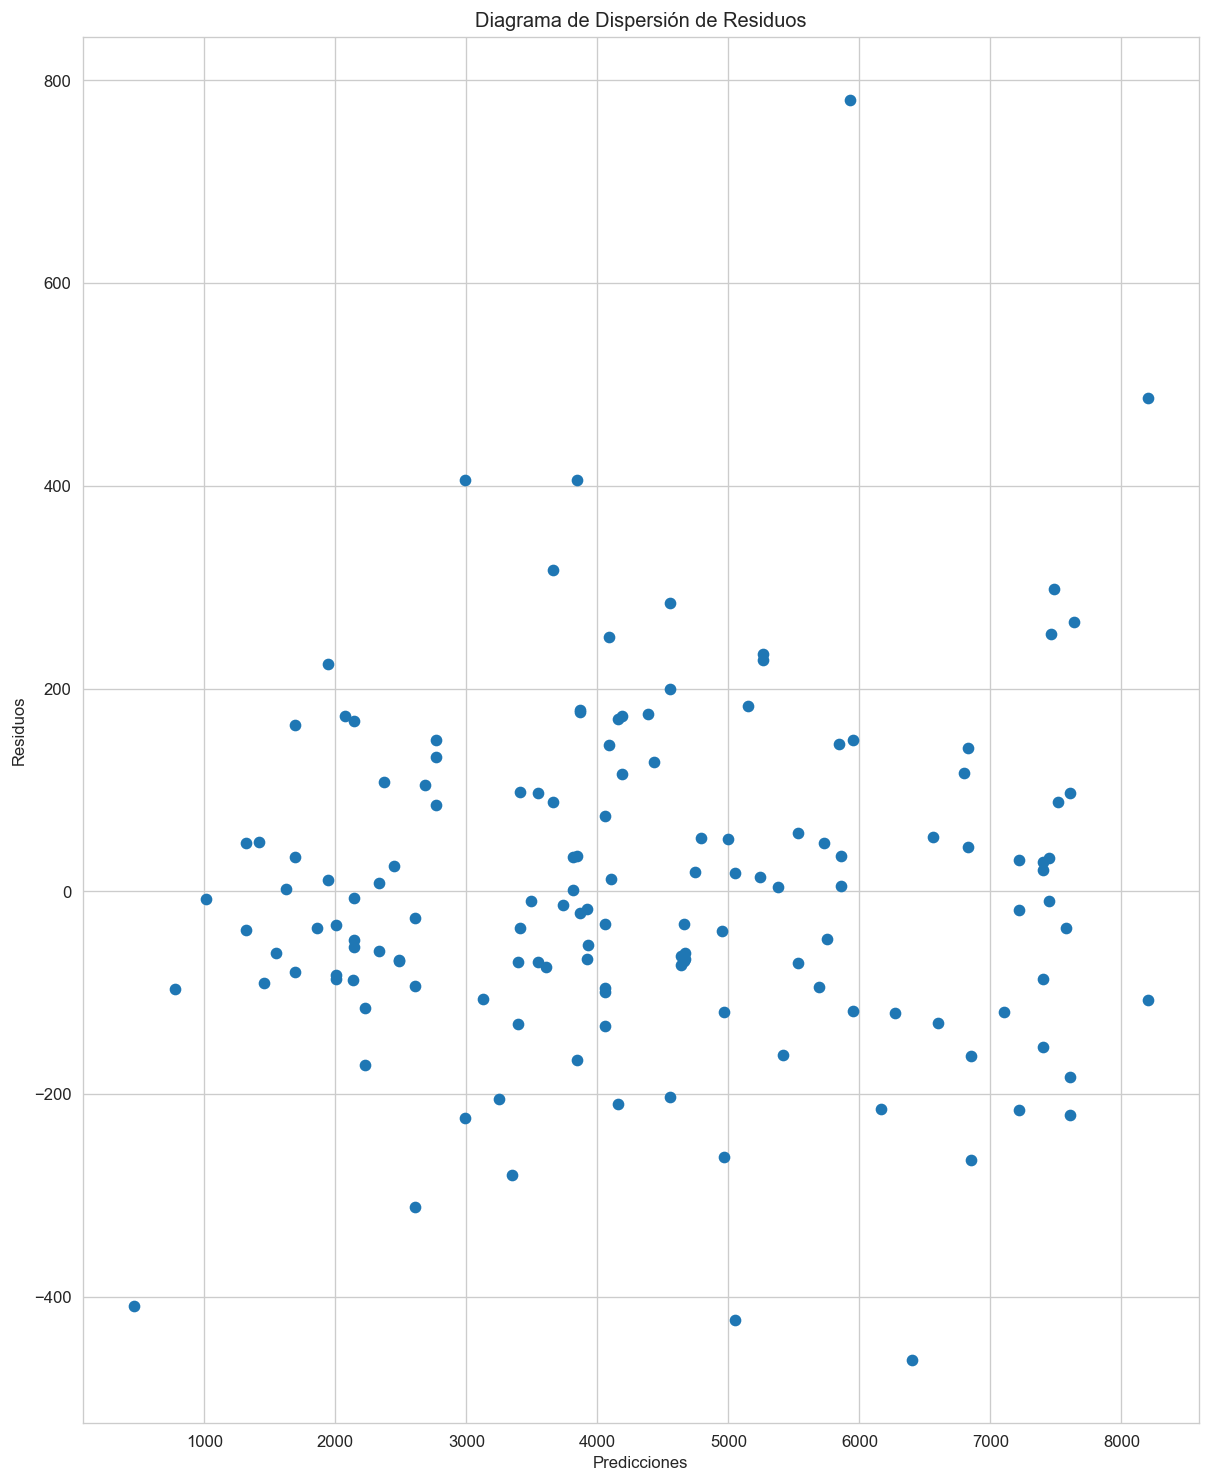

In [112]:
plt.scatter(y_pred, residuos)
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Diagrama de Dispersión de Residuos')
plt.show()

No hay relaciones sistemáticas entre las predicciones y los residuos

Aplicamos GridSearch para ver si existen hiperparametros para mejorar el modelo

In [109]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

tree_model = DecisionTreeRegressor(random_state=42)

grid_search = GridSearchCV(tree_model, param_grid, cv=5, scoring='r2')

grid_search.fit(X_train, y_train)

print("Mejores Hiperparámetros:", grid_search.best_params_)

best_tree_model = grid_search.best_estimator_

y_pred = best_tree_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R-squared en conjunto de prueba: {r2}')


Mejores Hiperparámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
R-squared en conjunto de prueba: 0.9931888776609769


Se comprueba que existen ciertos parametros entonces para lograr un mejor ajuste del modelo

## Prueba modelo ARIMA

In [66]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from timeit import default_timer as timer

import warnings
warnings.filterwarnings('ignore')

Realizaremos la prueba Dickey-Fuller para comprobar la estacionariedad de la serie de tiempo necesaria para aplicar el modelo ARIMA

Estadística de la prueba Dickey-Fuller: -1.8603845885842616
Valor p: 0.350920653633732
Valores críticos: {'1%': -3.4396861854831964, '5%': -2.865660062273053, '10%': -2.5689640195342456}


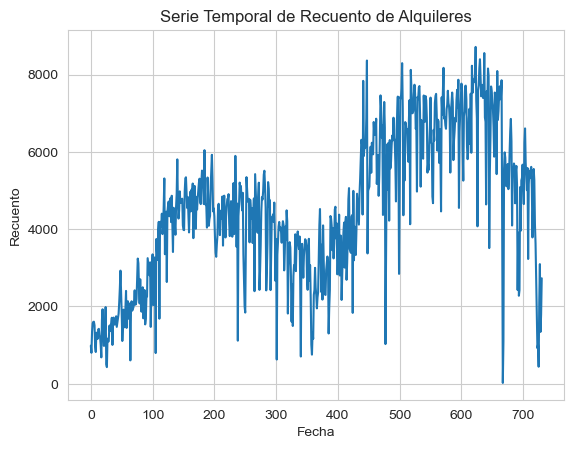

In [70]:
df_bicismod1 = df_bicismod.copy()
df_bicismod1['Fecha_y_Hora'] = pd.to_datetime(df_bicismod['Fecha_y_Hora'])

df_bicismod1.set_index('Fecha_y_Hora', inplace=True)

resultado_adfuller = adfuller(df_bicismod1['Recuento'])

print('Estadística de la prueba Dickey-Fuller:', resultado_adfuller[0])
print('Valor p:', resultado_adfuller[1])
print('Valores críticos:', resultado_adfuller[4])

plt.plot(df_bicismod['Recuento'])
plt.title('Serie Temporal de Recuento de Alquileres')
plt.xlabel('Fecha')
plt.ylabel('Recuento')
plt.show()


No podemos rechazar la hipotesis nula de no estacionariedad, por lo tanto procedemos a diferenciar la serie en busca de generar la misma

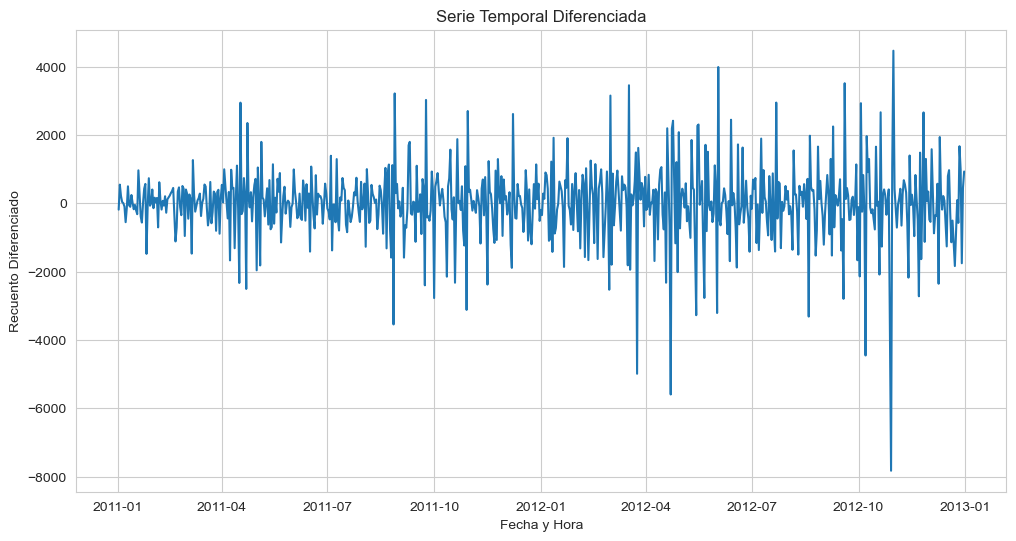

In [73]:
df_bicismod1['Recuento_diff'] = df_bicismod1['Recuento'].diff()

plt.figure(figsize=(12, 6))
plt.plot(df_bicismod1.index, df_bicismod1['Recuento_diff'])  
plt.title('Serie Temporal Diferenciada')
plt.xlabel('Fecha y Hora')
plt.ylabel('Recuento Diferenciado')
plt.show()

Volvemos a aplicar la prueba Dickey-Fuller

In [74]:
df_bicismod1.dropna(inplace=True)

result = adfuller(df_bicismod1['Recuento_diff'])

print('Estadística de la prueba Dickey-Fuller:', result[0])
print('Valor p:', result[1])
print('Valores críticos:', result[4])

Estadística de la prueba Dickey-Fuller: -11.967922438792485
Valor p: 3.9603057071563596e-22
Valores críticos: {'1%': -3.4396861854831964, '5%': -2.865660062273053, '10%': -2.5689640195342456}


Se comprueba entonces la estacionariedad de la serie procedemos a realizar graficos de autocorrelacion 

En un contexto de modelado de series temporales, los gráficos de autocorrelación (ACF) y autocorrelación parcial (PACF) son herramientas clave para entender la estructura temporal de la serie. La ACF muestra la correlación entre observaciones en diferentes lags, mientras que la PACF aísla las correlaciones directas en un lag específico. Un pico inicial seguido de un decaimiento en ACF sugiere una posible componente autorregresiva (AR), ya que lags sucesivos tienen menos correlación. Una PACF que comienza alto y decae podría indicar un componente AR con el lag inicial siendo significativo. La presencia de lags significativos en ambos gráficos sugiere la posibilidad de un modelo ARIMA con términos autorregresivos y de media móvil. 

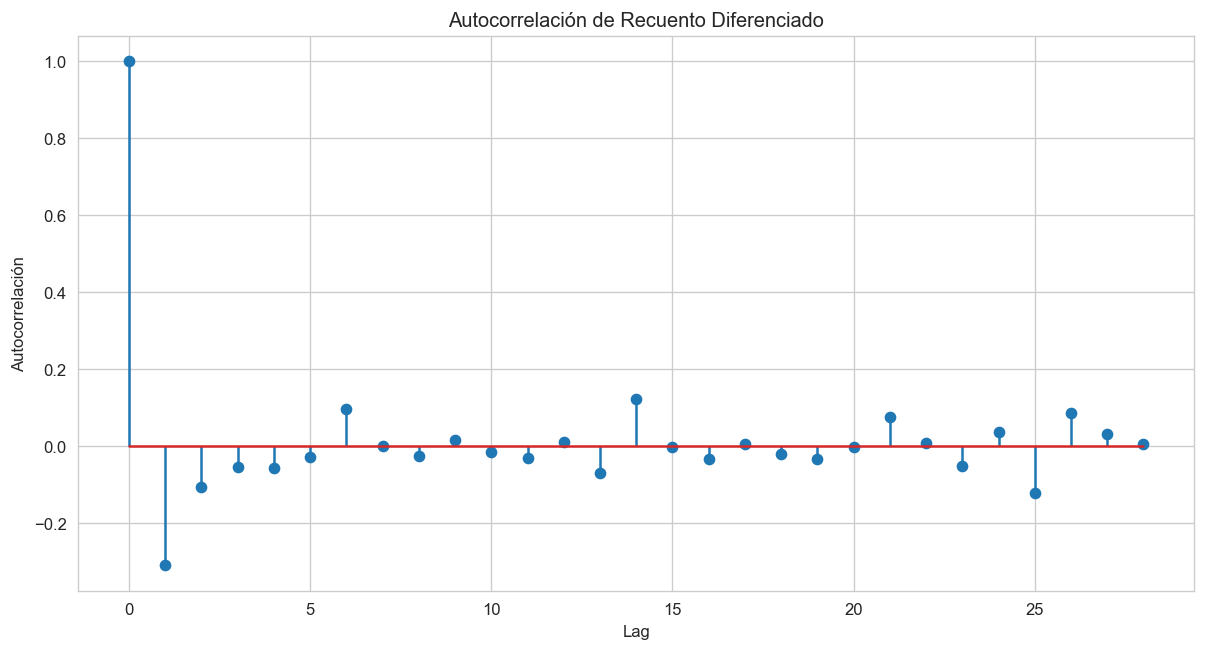

In [76]:
acf = sm.tsa.acf(df_bicismod1['Recuento_diff'].dropna())

plt.figure(figsize=(12, 6))
plt.stem(acf)
plt.title('Autocorrelación de Recuento Diferenciado')
plt.xlabel('Lag')
plt.ylabel('Autocorrelación')
plt.show()

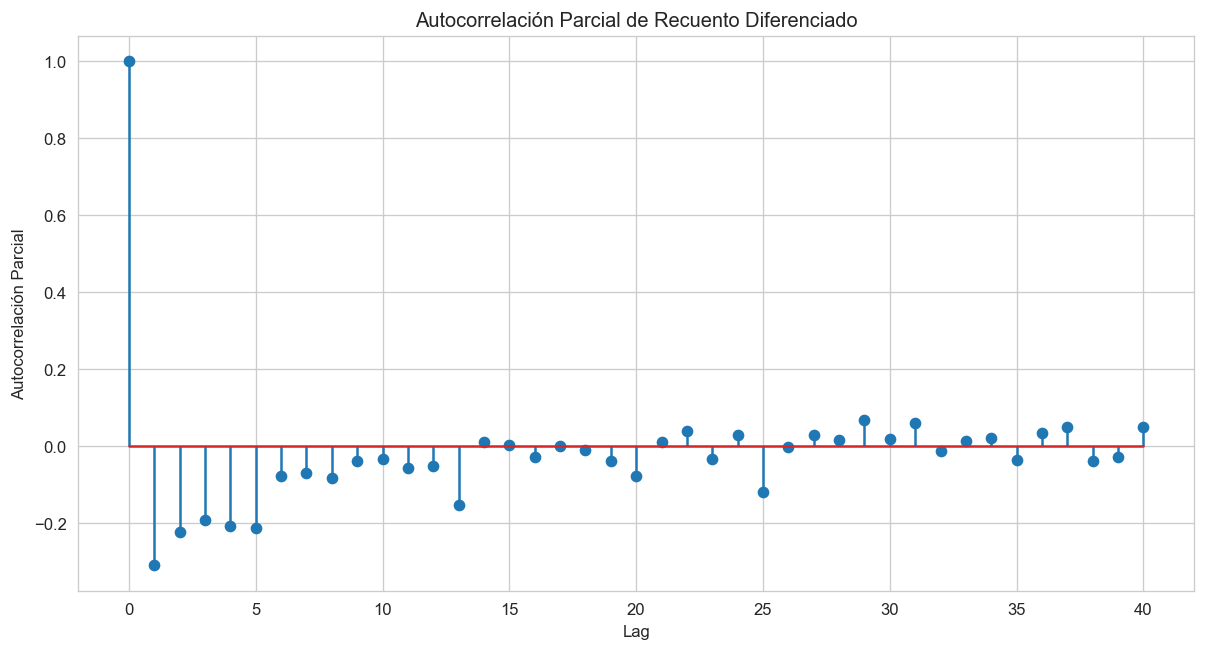

In [78]:
import statsmodels.api as sm

pacf = sm.tsa.pacf(df_bicismod1['Recuento_diff'].dropna(), nlags=40, method='ols')

plt.figure(figsize=(12, 6))
plt.stem(pacf, use_line_collection=True)
plt.title('Autocorrelación Parcial de Recuento Diferenciado')
plt.xlabel('Lag')
plt.ylabel('Autocorrelación Parcial')
plt.show()

In [83]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_bicismod1['Recuento_diff'].dropna(), order=(1, 1, 1))
results = model.fit()

results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          Recuento_diff   No. Observations:                  716
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5981.139
Date:                Sun, 03 Mar 2024   AIC                          11968.278
Time:                        08:57:53   BIC                          11981.994
Sample:                             0   HQIC                         11973.575
                                - 716                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3094      0.030    -10.474      0.000      -0.367      -0.252
ma.L1         -1.0000      0.025    -40.795      0.000      -1.048      -0.952
sigma2      1.071e+06   2.29e-08   4.68e+13      0.000    1.07e+06    1.07e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.51   Jarque-Bera (JB):              1738.48
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               3.25   Skew:                            -1.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.39e+27. Standard errors may be unstable.
"""

Se observa heterocedasticidad en los residuos y la prueba de normalidad indica que los residuos no siguen una distribución normal.

In [84]:
sm.stats.acorr_ljungbox(results.resid, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,77.268265,1.718654e-12


Los residuos no son independientes, lo cual podría indicar que hay patrones en los datos que el modelo no está capturando completamente.

Esto indica que el modelo ARIMA(1, 1, 1) puede no ser completamente adecuado para explicar la variabilidad en los datos, y hay patrones sistemáticos en los residuos que podrían indicar áreas de mejora en la especificación del modelo.